In [3]:
from pathlib import Path

# Automatically get the base path of your project
base_path = Path.cwd().parents[0]  # adjust .parents[0] if needed
print("Base path of the project:", base_path)

Base path of the project: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db


In [ ]:
# This code is more robust and will work regardless of the current working directory.
# Make sure that base_path is defined correctly.
# Ensure that the required packages are installed from the requirements.txt file
!pip3 install -r "{base_path}/requirements.txt"

### Step 1-2: Load De Novo Peptides and Prepare for DIAMOND Alignment

In this pipeline, we aim to identify microbial taxa by aligning de novo peptide sequences to the UniRef100 protein database using **DIAMOND** (a fast sequence aligner). Unlike the `pept2lca` pipeline that relies on peptide-level taxonomy (via UniPept), this approach uses **protein-level matches** and maps those proteins back to organisms using UniProt annotations.

These first two blocks perform the following:
1. **Define the path to the DIAMOND database** built from the UniRef100 FASTA.
2. **Load and filter** the de novo peptide predictions, retaining only high-confidence sequences (ALC > 70%).

These peptides will later be aligned to the UniRef100 database using DIAMOND to obtain the best-matching protein accession IDs for taxonomic annotation.


In [ ]:
# Define the path to the DIAMOND database (must end in .dmnd and be created beforehand)
# Example: downloaded and built from UniRef100 using diamond makedb
diamond_db = r"E:\Uniref100.dmnd"  # Update this path based on where your .dmnd file is located

In [ ]:
# Import pandas for data handling
import pandas as pd

# === Step 1: Load the de novo peptide dataset ===

# Define the path to the CSV file containing de novo peptide predictions
# Replace 'base_path' with your project-specific base path if necessary
de_novo_data_path = base_path / "de_novo_data" / "de_novo_garmerwolde.csv"

# Load the CSV into a pandas DataFrame
df = pd.read_csv(de_novo_data_path)

# Display the full shape of the dataset (rows, columns)
print(f"Original dataset shape: {df.shape}")

# Preview a subset of rows for inspection (use iloc with zero-based indexing)
print("Original Data (rows 24219-24227):")
display(df.iloc[24218:24228])

# === Step 2: Filter peptides based on ALC (Average Local Confidence) score ===

# Retain only high-confidence peptide sequences with ALC > 70%
filtered_df = df[df["ALC (%)"] > 70]

# Display the filtered dataset shape
print(f"Filtered dataset shape: {filtered_df.shape}")

# Preview the same range of rows after filtering (if still present)
print("Filtered Data (rows 24219-24227):")
display(filtered_df.iloc[24218:24228])  # Only shows output if those rows survived filtering

# Display how many peptides were removed in the filtering step
print(f"Number of peptides filtered out: {df.shape[0] - filtered_df.shape[0]}")

Original dataset shape: (189185, 20)
Original Data (rows 24219-24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
24218,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,KYAYFPVWVNDDKMSLPLR,F2:51275,19,76,68,19,781.3988,3,143.42,142.11,0.0,2341.1929,-7.8,NaN,45 39 41 35 33 43 89 98 98 94 95 96 94 90 83 4...,KYAYFPVWVNDDKMSLPLR,HCD
24219,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:35083,MWALDLR,F1:38190,7,76,78,7,452.7394,2,113.16,129.39,34600.0,903.4636,0.6,NaN,56 71 84 79 79 85 90,MWALDLR,HCD
24220,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:98838,LAAALTPAPVLAK,F2:33083,13,76,70,13,618.3896,2,100.95,110.95,13200000.0,1234.7649,-0.2,NaN,48 50 80 99 100 100 99 96 33 31 48 45 82,LAAALTPAPVLAK,HCD
24221,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:83383,APMSGLQNWK,F2:29687,10,76,70,10,566.2845,2,92.40,83.12,215000.0,1130.5542,0.3,NaN,96 94 85 92 82 41 28 21 69 92,APMSGLQNWK,HCD
24222,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:107262,SLTAPSGVPGM(+15.99)FK,F2:26077,13,76,67,13,654.3237,2,83.51,83.66,75700.0,1306.6592,-20.1,Oxidation (M),37 46 79 93 95 96 88 84 23 17 26 89 97,SLTAPSGVPGM(+15.99)FK,HCD
24223,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:139236,EVQAWSWWWM(+15.99)TRRAAMDVPGR,F2:49588,21,76,68,21,879.0955,3,139.45,141.68,822000.0,2634.2371,10.4,Oxidation (M),37 25 33 44 44 41 81 84 90 88 90 40 52 96 95 8...,EVQAWSWWWM(+15.99)TRRAAMDVPGR,HCD
24224,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:3957,MGFYGGR,F2:13573,7,76,68,7,394.1815,2,50.45,47.75,376000.0,786.3483,0.3,NaN,17 29 90 86 80 83 90,MGFYGGR,HCD
24225,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:103943,TLGALDGTN(+.98)MNR,F1:23486,12,76,71,12,632.3035,2,78.32,67.85,3660000.0,1262.5925,0.0,Deamidation (NQ),21 21 26 76 99 98 90 88 70 82 91 93,TLGALDGTN(+.98)MNR,HCD
24226,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:23734,LGGLSSAMK,F1:16822,9,76,75,9,432.2354,2,59.98,63.31,416000.0,862.4582,-2.4,NaN,62 77 48 88 82 73 68 78 97,LGGLSSAMK,HCD
24227,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LDQ(+.98)AHLYNWQWYR,F2:50574,13,76,77,13,897.4365,2,141.76,127.6,0.0,1792.8320,14.8,Deamidation (NQ),31 38 40 61 54 99 98 96 96 94 95 98 100,LDQ(+.98)AHLYNWQWYR,HCD


Filtered dataset shape: (32111, 20)
Filtered Data (rows 24219-24227):


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
25984,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,-,LVTTDANGWYNK,F2:16205,12,75,73,12,691.3395,2,57.63,71.8,0.0,1380.6675,-2.1,NaN,59 60 95 95 95 89 83 70 69 28 43 98,LVTTDANGWYNK,HCD
25985,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:39500,KATSLMDR,F2:7950,8,75,76,8,461.2376,2,32.97,17.78,841000.0,920.4749,-15.5,NaN,77 34 38 87 93 88 96 94,KATSLMDR,HCD
25986,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:103841,WAADLDQ(+.98)MVTK,F2:42699,11,75,75,11,639.8031,2,123.18,107.95,110000.0,1277.5962,-3.6,Deamidation (NQ),78 60 90 90 89 94 89 69 28 41 98,WAADLDQ(+.98)MVTK,HCD
25989,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:18876,Q(+.98)VYLHMDGFR,F1:35026,10,75,72,10,422.8690,3,105.90,95.37,300000.0,1265.5862,-0.9,Deamidation (NQ),26 28 45 61 92 95 98 92 94 96,Q(+.98)VYLHMDGFR,HCD
25990,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:113009,TLLPALYLLQGR,F2:54646,12,75,74,12,679.4126,2,151.38,164.41,25200.0,1356.8130,-1.7,NaN,51 50 50 33 82 89 93 95 85 79 88 98,TLLPALYLLQGR,HCD
25991,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:139595,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,F1:54391,22,75,72,22,847.3984,3,151.74,161.24,6010000.0,2539.1841,-4.2,Deamidation (NQ); Carbamidomethylation,49 40 57 62 82 96 69 44 92 49 28 34 96 97 97 8...,FGFGLSDPDDN(+.98)NLFAHFKPLC(+57.02)K,HCD
25993,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,-,YHDALTYVWNWGGFTGK,F1:45457,17,75,85,17,1007.9756,2,130.26,163.81,0.0,2013.9373,-0.3,NaN,34 20 62 78 99 99 98 98 98 97 98 97 97 98 98 9...,YHDALTYVWNWGGFTGK,HCD
25994,1,MP_RZ07032023_GW_flat_180min_DDA01.raw,F1:852,NSLAVLR,F1:12592,7,75,81,7,386.7372,2,48.50,66,1480000.0,771.4603,-0.4,NaN,61 60 82 92 94 94 86,NSLAVLR,HCD
25995,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:141090,NYLDDLR,F2:41876,7,75,85,7,908.4518,1,121.32,83.38,208000.0,907.4399,5.0,NaN,85 83 85 82 85 88 90,NYLDDLR,HCD
25997,2,MP_RZ07032023_GW_flat_180min_DDA02.raw,F2:129117,YM(+15.99)APQEVGPGSPFR,F2:34615,14,75,78,14,776.3701,2,104.14,93.71,57400.0,1550.7188,4.5,Oxidation (M),37 35 43 41 90 96 95 97 93 92 94 82 95 100,YM(+15.99)APQEVGPGSPFR,HCD


Number of peptides filtered out: 157074


### Step 3: Clean Peptide Sequences Before DIAMOND Alignment

Before aligning de novo peptides to the UniRef100 database, we standardize the peptide sequences to ensure compatibility with database protein entries.

This includes:
- **Removing post-translational modification annotations** (e.g., `+16` or brackets)
- **Equating Leucine (L) and Isoleucine (I)**, which are indistinguishable by MS/MS
- Adding a new column `"Cleaned Sequence"` to the filtered dataframe for downstream use

This preprocessing ensures that the peptide sequences better match the actual content of UniRef protein databases and increases alignment sensitivity.


In [ ]:
# Import regular expression module for string cleaning
import re

# === Step 1: Define a function to clean peptide sequences ===

def wrangle_peptides(sequence: str, ptm_filter: bool = True, li_swap: bool = True) -> str:
    """
    Clean and normalize peptide sequences by removing PTMs and optionally 
    replacing Leucine (L) with Isoleucine (I).

    Args:
        sequence (str): The raw peptide sequence string from de novo prediction.
        ptm_filter (bool): Whether to remove post-translational modifications.
        li_swap (bool): Whether to replace 'L' with 'I' for MS/MS ambiguity.

    Returns:
        str: A cleaned peptide sequence.
    """
    
    # If PTM filtering is enabled, remove any non-alphabetic characters (e.g., +16, (), etc.)
    if ptm_filter:
        sequence = "".join(re.findall(r"[A-Z]+", sequence))  # Keep only A-Z characters

    # If enabled, replace Leucine (L) with Isoleucine (I)
    if li_swap:
        sequence = sequence.replace("L", "I")

    # Return the cleaned sequence string
    return sequence

# === Step 2: Apply the cleaning function to the peptide column ===

# Create a new column called 'Cleaned Sequence' with the cleaned peptide strings
filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))

# Print the shape of the updated DataFrame to confirm modification
print("Shape of the filtered DataFrame after adding the new column:")
display(filtered_df.shape)

# Preview rows 11–21 of the original and cleaned sequences for comparison
print("Cleaned Peptides (Rows 11-21):")
display(filtered_df[["Peptide", "Cleaned Sequence"]].iloc[10:21])


Shape of the filtered DataFrame after adding the new column:


C:\Temp\ipykernel_17440\2169065453.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Cleaned Sequence"] = filtered_df["Peptide"].apply(lambda x: wrangle_peptides(x))


(32111, 21)

Cleaned Peptides (Rows 11-21):


,Peptide,Cleaned Sequence
10,TSLLN(+.98)YLR,TSIINYIR
11,VVQLTMQ(+.98)TQEK,VVQITMQTQEK
12,ATMSDFSPK,ATMSDFSPK
13,LSELTSLTSAPR,ISEITSITSAPR
14,VSQ(+.98)AVLAASSGR,VSQAVIAASSGR
15,VGLAWDR,VGIAWDR
16,YLPASC(+57.02)R,YIPASCR
17,ASVEDLLK,ASVEDIIK
18,YPDVATTHGGSATK,YPDVATTHGGSATK
19,VMGVAFN(+.98)R,VMGVAFNR


### Step 4: Automatically Check and Install DIAMOND on Windows

To perform protein alignments using the DIAMOND aligner, we must ensure the DIAMOND binary is available locally.

This block:
- **Checks if `diamond.exe` is already present** in the `software_tools` directory.
- If not, it **downloads the latest Windows binary** from the official GitHub repository.
- **Extracts the executable** and removes the ZIP file after setup.

This script supports only Windows environments. On Linux/Mac, users must install DIAMOND manually and point to the correct path.

> This automation avoids installation errors and ensures reproducibility across users and sessions.


In [ ]:
# Import modules needed for file handling, downloading, OS checking, and ZIP extraction
import os
import urllib.request
import zipfile
import platform

# === Define where DIAMOND is expected to be located ===

# Path to where we expect the diamond executable to be
diamond_exe = base_path / "software_tools" / "diamond.exe"

# URL to download the latest Windows release of DIAMOND
diamond_url = "https://github.com/bbuchfink/diamond/releases/latest/download/diamond-windows.zip"

# Name of the temporary ZIP file to download
download_path = "diamond-windows.zip"

# === Proceed only on Windows systems ===
if platform.system() == "Windows":
    
    # Check if diamond.exe already exists
    if not os.path.exists(diamond_exe):
        print("DIAMOND not found — downloading latest release...")

        # Step 1: Download the ZIP file from the official GitHub repo
        urllib.request.urlretrieve(diamond_url, download_path)
        print("Downloaded diamond-windows.zip")

        # Step 2: Extract all contents from the ZIP archive
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall()  # Extracts to the current working directory
            print("Extracted files:", zip_ref.namelist())

        # Step 3: Remove the ZIP file after extraction to clean up
        os.remove(download_path)
        print("DIAMOND setup complete")
    
    else:
        # If the executable already exists, skip installation
        print("DIAMOND is already available")

else:
    # Message for non-Windows users (Linux/macOS)
    print("This script is designed for Windows only. Please install DIAMOND manually for this OS.")



DIAMOND is already available


### Step 5: Export Cleaned Peptides to FASTA Format for DIAMOND Alignment

DIAMOND requires input sequences in FASTA format. This step takes all high-confidence, cleaned de novo peptides and writes them to a `.fasta` file.

Each peptide is given a unique header (e.g., `>peptide_0`, `>peptide_1`, ...) followed by its amino acid sequence. This format is critical for ensuring DIAMOND can align each sequence and associate results with the correct peptide.

The resulting FASTA file will be used in the next step where we run DIAMOND to align peptides against the UniRef100 database.


In [ ]:
# Import Path for cross-platform file path handling
from pathlib import Path

# === Define a function to save peptide sequences to FASTA format ===

def save_peptides_to_fasta(df, fasta_path, peptide_column="Cleaned Sequence"):
    """
    Write cleaned peptide sequences to a FASTA file for DIAMOND alignment.

    Args:
        df (pd.DataFrame): DataFrame containing peptide sequences.
        fasta_path (str or Path): Output path for the FASTA file.
        peptide_column (str): Name of the column containing peptide sequences.
    """
    # Open the FASTA file in write mode
    with open(fasta_path, "w") as f:
        # Write each peptide with a unique header line and the sequence
        for i, pep in enumerate(df[peptide_column]):
            f.write(f">peptide_{i}\n{pep}\n")  # FASTA format: >header \n sequence
    print(f"Saved {len(df)} peptides to {fasta_path}")

# Define the output path for the peptide FASTA file
peptide_fasta = base_path / "peptides.fasta"

# Call the function to save all cleaned peptides from filtered_df to FASTA
save_peptides_to_fasta(filtered_df, peptide_fasta)



Saved 32111 peptides to c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\peptides.fasta


### Step 6: Ensure PAM70 Substitution Matrix is Available

Certain alignment tools (like DIAMOND or NovoLign) support using custom substitution matrices to adjust scoring schemes. The **PAM70 matrix** reflects moderate evolutionary distance and is often used for peptide/protein alignments.

This block:
- Defines the local path where `PAM70.mat` should exist.
- Downloads the matrix file from a trusted GitHub source if it’s missing.

Although DIAMOND doesn’t strictly require PAM70 (it has its own built-in matrices), this step allows for compatibility with workflows or tools (like NovoLign) that explicitly use PAM70 for scoring.


In [21]:
# Import modules for file checks and downloading
import os
import urllib.request

# === Step 1: Define file path and source URL ===

# Local file path where PAM70.mat should be saved
pam70_path = base_path / "software_tools" / "PAM70.mat"

# URL to download the PAM70 matrix file from GitHub (NovoLign repository)
pam70_url = "https://raw.githubusercontent.com/hbckleikamp/NovoLign/main/PAM70.mat"

# === Step 2: Check if PAM70.mat exists locally, otherwise download ===

# If the file already exists, no need to download it again
if os.path.exists(pam70_path):
    print("PAM70.mat already exists")
else:
    # If file is missing, download it from the GitHub repo
    print("PAM70.mat not found. Downloading...")
    urllib.request.urlretrieve(pam70_url, pam70_path)
    print("PAM70.mat downloaded successfully")

PAM70.mat already exists


### Step 7: Run DIAMOND to Align Peptides Against UniRef100 Database

With the cleaned peptides exported in FASTA format and the UniRef100 `.dmnd` database ready, this block executes the **DIAMOND alignment**.

Key features:
- Uses **DIAMOND blastp** mode to align peptide sequences to protein sequences.
- Applies **custom alignment parameters** to increase specificity, including:
  - Minimum identity (`--id 85`)
  - Minimum query coverage (`--query-cover 80`)
  - Custom gap penalties and score thresholds
- Uses the **PAM70 substitution matrix** if available, for better MS/MS relevance.
- Outputs results in a custom tabular format with query/subject IDs, scores, and sequences.

The resulting `.tsv` file lists the best protein hits for each peptide, which will be used in downstream taxonomic annotation.


In [ ]:
# Import required modules for running shell commands and handling paths
import os
import subprocess

# === Define paths for input, output, and DIAMOND binary ===

# Path to DIAMOND executable
diamond_exe = base_path / "software_tools" / "diamond.exe"

# Path to the cleaned peptide FASTA file created earlier
query_fasta = base_path / "peptides.fasta"

# Directory and file where DIAMOND alignment results will be saved
output_dir = base_path / "Diamond_alignments"
output_file = os.path.join(output_dir, "de_novo_peptides_uniref100_aligned.tsv")

# Ensure the output directory exists (create if not)
os.makedirs(output_dir, exist_ok=True)

# === Build the DIAMOND command with alignment parameters ===

diamond_command = [
    diamond_exe, "blastp",                 # Run DIAMOND in protein-protein alignment mode
    "-q", query_fasta,                     # Input query FASTA (peptides)
    "-d", diamond_db,                      # UniRef100 DIAMOND database
    "-o", output_file,                     # Output file path
    "-k", "50",                            # Report up to 50 best hits per peptide
    "--id", "85",                          # Require minimum 85% identity
    "--query-cover", "80",                 # Require at least 80% of the peptide to align
    "--min-score", "20",                   # Minimum alignment score threshold
    "--gapopen", "2",                      # Penalty for opening a gap
    "--gapextend", "4",                    # Penalty for extending a gap
    "--algo", "ctg",                       # Use "contiguous" algorithm (fast & strict)
    "-f", "6", "qseqid", "sseqid",         # Output format: tabular with selected columns
           "pident", "bitscore", "qseq", "sseq"
]

# === Add PAM70 matrix if available ===

pam70_path = base_path / "software_tools" / "PAM70.mat"
if os.path.exists(pam70_path):
    diamond_command += ["--custom-matrix", pam70_path]  # Append custom matrix option
    print("Using custom scoring matrix PAM70.mat")

# === Run the DIAMOND command ===

print("Running DIAMOND alignment...")
try:
    # Execute the command; raise error if DIAMOND fails
    subprocess.run(diamond_command, check=True)
    print(f"DIAMOND alignment complete. Results saved to: {output_file}")
except subprocess.CalledProcessError as e:
    # Catch and report any failure in running DIAMOND
    print(f"❌ DIAMOND failed: {e}")



Using custom scoring matrix PAM70.mat
Running DIAMOND alignment...
DIAMOND alignment complete. Results saved to: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\Diamond_alignments\garmerwoldepeptides_uniref100_aligned.tsv


### Step 8: Load DIAMOND Alignment Results and Extract Matched Protein Accessions

After aligning the cleaned peptides to the UniRef100 database using DIAMOND, we now load the alignment results and extract the **matched protein IDs** (`sseqid` column). These accession IDs represent the UniRef protein entries that best match each peptide.

Key actions:
- Load the tabular DIAMOND result file (`.tsv`) into a pandas DataFrame.
- Assign column names based on DIAMOND's custom output format.
- Extract all **unique protein accession IDs**, which will be used in the next step to retrieve taxonomic information from UniProt.

This bridges the gap between peptide-level alignments and taxon-level assignments based on protein metadata.


In [ ]:
# Import pandas for data handling
import pandas as pd

# === Step 1: Load DIAMOND alignment output ===

# Define the full path to the DIAMOND result file
diamond_output_path = base_path / "Diamond_alignments" / "de_novo_peptides_uniref100_aligned.tsv"

# Define column names for the DIAMOND tabular output
columns = [
    "qseqid",    # Query sequence ID (e.g., peptide_0)
    "sseqid",    # Subject sequence ID (matched UniRef protein)
    "pident",    # Percent identity
    "bitscore",  # Bit score of alignment
    "qseq",      # Query sequence (peptide)
    "sseq"       # Matched portion of the protein sequence
]

# Read the result file into a DataFrame
diamond_df = pd.read_csv(diamond_output_path, sep="\t", header=None, names=columns)

# Print the total number of alignments (rows)
print(f"Loaded {len(diamond_df)} alignments.")
display(diamond_df.shape)  # Show shape of the DataFrame (rows, columns)

# Display the top rows for inspection
display(diamond_df.head())

# === Step 2: Extract unique protein accession IDs ===

# Get all unique values from the 'sseqid' column (UniRef protein accessions)
unique_proteins = diamond_df["sseqid"].unique()

# Print how many distinct protein accessions were matched
print(f"Found {len(unique_proteins)} unique matched protein IDs.")


Loaded 59329 alignments.


(59329, 6)

,qseqid,sseqid,pident,bitscore,qseq,sseq
0,peptide_2,UniRef100_A0A011QQ48,100.0,24.8,MAGSQTAMTR,MAGSQTAMTR
1,peptide_2,UniRef100_UPI0025C051C6,100.0,24.8,MAGSQTAMTR,MAGSQTAMTR
2,peptide_2,UniRef100_UPI0028C430E3,100.0,24.8,MAGSQTAMTR,MAGSQTAMTR
3,peptide_2,UniRef100_UPI0025B9E656,100.0,24.8,MAGSQTAMTR,MAGSQTAMTR
4,peptide_2,UniRef100_UPI00145EEA31,100.0,24.8,MAGSQTAMTR,MAGSQTAMTR


Found 33301 unique matched protein IDs.


### Step 9: Extract UniProt Accessions from Matched UniRef IDs

The subject sequence IDs (`sseqid`) returned by DIAMOND are typically UniRef cluster headers, such as:
UniRef90_A0A1S2ZP88
UniRef100_Q8WZ42

In these identifiers, the actual **UniProt accession** is the suffix (e.g., `A0A1S2ZP88`, `Q8WZ42`). We need to extract these accessions to:
- Use them in UniProt's ID mapping API to retrieve organism-level annotations.
- Link peptides to taxonomic lineages via the protein match.

This block:
- Uses a regular expression to extract the trailing UniProt accession from each `sseqid`.
- Adds a new `"accession"` column to the `diamond_df` with these extracted IDs.
- Prepares a list of **unique, valid accession IDs** for API submission.


In [ ]:
# Import regular expressions for parsing sequence IDs
import re

# === Step 1: Define function to extract UniProt accession from sseqid ===

def extract_accession(sseqid):
    """
    Extract the UniProt accession from a UniRef ID string.

    Example:
        "UniRef90_A0A1S2ZP88" → "A0A1S2ZP88"

    Args:
        sseqid (str): Subject sequence ID from DIAMOND result.

    Returns:
        str or None: Extracted UniProt accession, or None if not matched.
    """
    # Match the last alphanumeric group in the string
    match = re.search(r"[A-Z0-9]+$", sseqid)
    return match.group(0) if match else None

# === Step 2: Apply the extraction function to each matched sequence ID ===

# Create a new column 'accession' with the extracted UniProt IDs
diamond_df["accession"] = diamond_df["sseqid"].apply(extract_accession)

# === Step 3: Display and verify results ===

# Show shape of the updated DataFrame
display(diamond_df.shape)

# Show a sample of sseqid and corresponding extracted accession
display(diamond_df[["sseqid", "accession"]].drop_duplicates().head())

# === Step 4: Count valid unique accession IDs ===

# Get all unique, non-null accession values
accessions = diamond_df["accession"].dropna().unique().tolist()

# Print how many accessions will be mapped to taxonomic info
print(f"Accessions to map: {len(accessions)}")

(59329, 7)

,sseqid,accession
0,UniRef100_A0A011QQ48,A0A011QQ48
1,UniRef100_UPI0025C051C6,UPI0025C051C6
2,UniRef100_UPI0028C430E3,UPI0028C430E3
3,UniRef100_UPI0025B9E656,UPI0025B9E656
4,UniRef100_UPI00145EEA31,UPI00145EEA31


✅ Accessions to map: 33301


### Step 10: Map Matched Protein Accessions to Organism Names via UniProt ID Mapping API

To annotate each matched protein with the corresponding **organism name**, we use UniProt's ID Mapping API. Since thousands of protein accessions may be involved, we batch them into manageable chunks and submit them to the API.

The process includes:
1. **Chunking the UniProt accessions** extracted from the DIAMOND results.
2. **Submitting mapping jobs** using UniProt’s `run`, `status`, and `results` endpoints.
3. **Paginating through results**, combining all chunks into one DataFrame.
4. **Mapping organisms back to the DIAMOND alignment table**, linking each peptide to a taxonomic origin.

Finally, we **save the annotated alignment table** with an `"organism"` column, which is crucial for downstream filtering and database construction.


In [ ]:
# Import necessary modules for API calls, timing, and data manipulation
import requests
import pandas as pd
import time
from io import StringIO

# === CONFIGURATION ===

CHUNK_SIZE = 500              # Number of accessions per API job (can go up to ~9500)
SLEEP_BETWEEN_JOBS = 5        # Delay between jobs to avoid rate-limiting

# === STEP 1: Prepare Accessions ===

# Get unique UniProt accessions (previously extracted from UniRef IDs)
accessions = diamond_df["accession"].dropna().unique().tolist()
print(f"Total unique accessions: {len(accessions)}")

# === UniProt Mapping Helper Functions ===

def submit_uniprot_mapping(accessions_chunk):
    """
    Submit a chunk of UniProt accessions to the ID mapping API.
    Returns the job ID.
    """
    url = "https://rest.uniprot.org/idmapping/run"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {
        "from": "UniProtKB_AC-ID",      # Source ID type
        "to": "UniProtKB",              # Target ID type (to get metadata)
        "ids": ",".join(accessions_chunk)
    }

    response = requests.post(url, data=data, headers=headers)
    response.raise_for_status()
    return response.json()["jobId"]

def wait_for_completion(job_id):
    """
    Poll the UniProt server until the mapping job has finished.
    """
    url = f"https://rest.uniprot.org/idmapping/status/{job_id}"
    while True:
        response = requests.get(url)
        response.raise_for_status()
        status = response.json()

        if status.get("jobStatus", "").upper() == "RUNNING":
            print("Still processing...")
            time.sleep(3)
        elif "redirectURL" in status or "results" in status or status.get("jobStatus", "").upper() == "FINISHED":
            print("Job completed.")
            break
        else:
            print("Status unclear, retrying...")
            time.sleep(3)

def download_results(job_id):
    """
    Download paginated UniProt results for a completed mapping job.
    Returns a combined pandas DataFrame.
    """
    print("⬇Downloading all paginated results...")
    base_url = f"https://rest.uniprot.org/idmapping/uniprotkb/results/{job_id}"
    headers = {"Accept": "text/tab-separated-values"}

    all_chunks = []
    next_url = base_url + "?format=tsv&fields=accession,organism_name&size=500"

    while next_url:
        response = requests.get(next_url, headers=headers)
        response.raise_for_status()
        chunk = pd.read_csv(StringIO(response.text), sep="\t")
        all_chunks.append(chunk)

        # Parse pagination headers
        link_header = response.headers.get("Link", "")
        if 'rel="next"' in link_header:
            parts = link_header.split(",")
            next_links = [p for p in parts if 'rel="next"' in p]
            if next_links:
                next_url = next_links[0].split(";")[0].strip("<> ")
            else:
                next_url = None
        else:
            next_url = None

    # Combine all downloaded chunks
    full_df = pd.concat(all_chunks, ignore_index=True)
    print(f"Downloaded total {len(full_df)} mapped accessions.")
    return full_df

# === STEP 2: Submit and Download Mappings in Batches ===

all_mappings = []

# Loop through all accessions in chunks
for i in range(0, len(accessions), CHUNK_SIZE):
    chunk = accessions[i:i+CHUNK_SIZE]
    print(f"\nSubmitting chunk {i//CHUNK_SIZE + 1}/{(len(accessions)//CHUNK_SIZE)+1} (size: {len(chunk)})")

    try:
        # Submit mapping job and wait for completion
        job_id = submit_uniprot_mapping(chunk)
        print(f"Job ID: {job_id}")
        wait_for_completion(job_id)

        # Download and store the results
        result_df = download_results(job_id)
        all_mappings.append(result_df)
        print(f"Mapped {len(result_df)} accessions.")
    except Exception as e:
        print(f"Error during chunk {i//CHUNK_SIZE + 1}: {e}")

    # Pause to avoid overloading the API
    time.sleep(SLEEP_BETWEEN_JOBS)

# === STEP 3: Combine Results and Annotate DIAMOND DataFrame ===

if all_mappings:
    # Combine all mapping chunks into a single DataFrame
    combined_df = pd.concat(all_mappings, ignore_index=True)
    print(f"\nTotal mapped entries: {len(combined_df)}")

    # Build dictionary: accession → organism name
    accession_to_org = dict(zip(combined_df["From"], combined_df["Organism"]))

    # Annotate the DIAMOND alignment table with organism names
    diamond_df["organism"] = diamond_df["accession"].map(accession_to_org)

    # Define output path for the updated DataFrame
    output_path = base_path / "Diamond_alignments" / "diamond_df_with_organisms_uniref100.csv"

    # Save to CSV
    diamond_df.to_csv(output_path, index=False)
    print(f"Saved updated diamond_df with organisms to: {output_path}")
else:
    print("No successful mappings. Check API or chunk errors.")


🔢 Total unique accessions: 33301

🚀 Submitting chunk 1/67 (size: 500)
🆔 Job ID: lqZD7cw9vC
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
✅ Job completed.
⬇️ Downloading all paginated results...
✅ Downloaded total 308 mapped accessions.
✅ Mapped 308 accessions.

🚀 Submitting chunk 2/67 (size: 500)
🆔 Job ID: bbHPe44MwE
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
✅ Job completed.
⬇️ Downloading all paginated results...
✅ Downloaded total 304 mapped accessions.
✅ Mapped 304 accessions.

🚀 Submitting chunk 3/67 (size: 500)
🆔 Job ID: eMSCsFKJI4
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
⏳ Still processing...
✅ Job completed.
⬇️ Downloading all paginated results...
✅ Downloaded total 328 mapped accessions.
✅ Mapped 328 accessions.

🚀 Submitting chunk 4/67 (size: 500)
🆔 Job ID: u6qGp0XVro
⏳ Still processing...
⏳ Still pro

### Step 11: Filter for Confident Organisms Based on Peptide Support

To ensure that we only include **reliably detected organisms** in our downstream database and analyses, we filter out those with low peptide support. Organisms supported by just a few peptides may be false positives or irrelevant background.

Key actions in this block:
- Load the previously annotated DIAMOND results with organism names.
- Count the number of peptide hits per organism.
- Filter to keep only organisms with **at least 15 matched peptides** (configurable).
- Save the filtered dataset for downstream use (e.g., taxonomic annotation, proteome collection).

This step strengthens the biological validity of the results and avoids overfitting or noise in custom database construction.


In [ ]:
# Import pandas for data handling
import pandas as pd

# === Step 1: Load the annotated DIAMOND alignment file ===

# Path to the CSV file that includes peptides + matched protein + organism info
file_path = base_path / "Diamond_alignments" / "diamond_df_with_organisms_uniref100.csv"

# Load the DataFrame into memory
df = pd.read_csv(file_path)

# === Step 2: Set minimum confidence threshold ===

# Define the minimum number of peptide matches required per organism
min_hits = 15

# Count the number of times each organism appears in the dataset
# This represents the number of peptide hits per organism
organism_counts = df["organism"].value_counts()

# === Step 3: Filter organisms based on hit count ===

# Get a list of organism names that meet or exceed the threshold
confident_organisms = organism_counts[organism_counts >= min_hits].index.tolist()

# Filter the DataFrame to include only rows corresponding to confident organisms
filtered_df = df[df["organism"].isin(confident_organisms)].reset_index(drop=True)

# === Step 4: Display summary ===

# Print the number of organisms retained after filtering
print(f"Retained {len(confident_organisms)} confident organisms with ≥ {min_hits} peptide hits")

# Optionally display the top 10 most frequent organisms for inspection
print("\nTop 10 most frequent organisms:")
display(organism_counts.head(10))

# === Step 5: Save the filtered DataFrame ===

# Define the output path for the filtered dataset
filtered_path = f"Diamond_alignments/diamond_df_filtered_{min_hits}_hits.csv"

# Save to CSV without row index
filtered_df.to_csv(filtered_path, index=False)

# Confirm export
print(f"\nFiltered dataset saved to: {filtered_path}")


✅ Retained 278 confident organisms with ≥ 15 peptide hits

🧬 Top 10 most frequent organisms:


organism
Nitrospira sp                              928
Accumulibacter sp                          924
Candidatus Competibacteraceae bacterium    899
Candidatus Accumulibacter phosphatis       865
Gammaproteobacteria bacterium              863
uncultured bacterium                       723
Nitrospirota bacterium                     585
Betaproteobacteria bacterium               558
Accumulibacter regalis                     480
Rhodocyclaceae bacterium                   456
Name: count, dtype: int64


💾 Filtered dataset saved to: Diamond_alignments/diamond_df_filtered_15_hits.csv


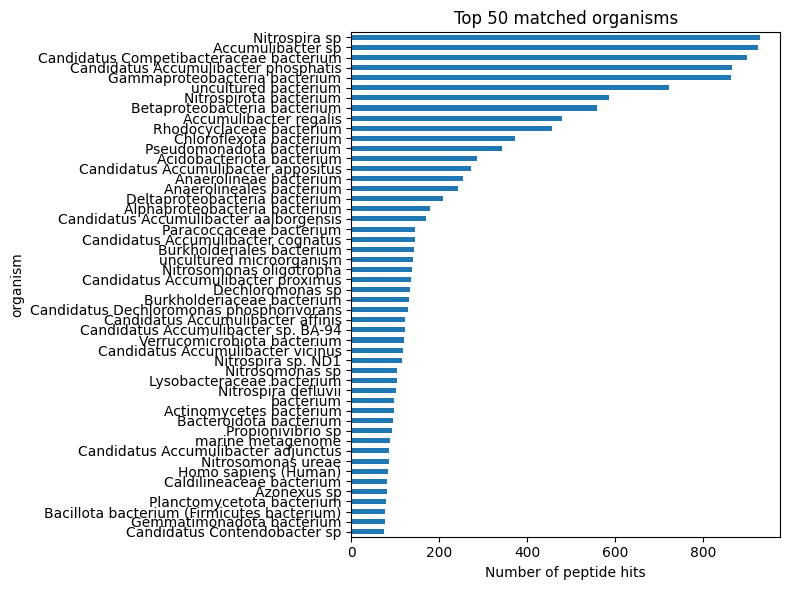

In [18]:
# Visualize the top 50 organisms with most peptide hits
import matplotlib.pyplot as plt
# Load mapped DIAMOND results
file_path = base_path / "Diamond_alignments" / "diamond_df_with_organisms_uniref100.csv"
df = pd.read_csv(file_path)
# Count number of unique peptide hits per organism
organism_counts = df["organism"].value_counts()

organism_counts.head(50).plot(kind="barh", figsize=(8,6), title="Top 50 matched organisms")
plt.xlabel("Number of peptide hits")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Step 12: Annotate Organisms with Taxonomic Ranks Using NCBI Entrez

Now that we’ve filtered our DIAMOND-aligned peptides to include only organisms with sufficient peptide support, we enrich the data by assigning **NCBI taxonomic ranks** (e.g., genus, species, phylum) to each organism.

This step:
- Queries the **NCBI Taxonomy database** via Biopython’s Entrez API.
- Retrieves the taxonomic **rank** of each unique organism name in the dataset.
- Adds a `"taxonomy_rank"` column to the main DataFrame.
- Saves the annotated file for downstream strategies (e.g., grouping by rank or prioritizing genus-level entries).

> Adding taxonomic rank context allows flexible database construction and robust comparison across pipelines or rank levels.


In [25]:
# Import required modules
import pandas as pd
from Bio import Entrez          # Biopython interface for NCBI
from time import sleep
from tqdm import tqdm           # Progress bar for API calls

# === Step 1: Configure NCBI Entrez ===

# Email and tool name used for NCBI API calls (good practice, not strictly required)
Entrez.email = "your_email@example.com" # You don't have to modify this
Entrez.tool = "TaxonRankFetcher"

# === Step 2: Load filtered dataset and extract unique organism names ===

# Load the DIAMOND result filtered by peptide hit threshold
filtered_path = f"Diamond_alignments/diamond_df_filtered_{min_hits}_hits.csv"
df = pd.read_csv(filtered_path)

# Extract all unique (non-null) organism names from the DataFrame
organisms = df["organism"].dropna().unique()

# === Step 3: Define lookup dictionary ===

# Will store organism → rank mapping
rank_lookup = {}

# === Step 4: Function to query NCBI and fetch taxonomic rank ===

def fetch_ncbi_rank(organism_name):
    """
    Retrieve the taxonomic rank for a given organism name from NCBI Taxonomy.
    Returns: e.g. 'genus', 'species', or 'not_found'/'error' if failed.
    """
    try:
        # Search for the organism name to get its taxonomy ID
        search = Entrez.esearch(db="taxonomy", term=organism_name, retmode="xml")
        record = Entrez.read(search)

        # If a valid taxon ID was found, fetch its taxonomy info
        if record["IdList"]:
            tax_id = record["IdList"][0]
            summary = Entrez.efetch(db="taxonomy", id=tax_id, retmode="xml")
            data = Entrez.read(summary)
            return data[0]["Rank"]  # Return the rank field (e.g. 'species')
        else:
            return "not_found"
    except Exception:
        return "error"

# === Step 5: Populate the lookup dictionary ===

print("Fetching ranks from NCBI...")

# Loop over each unique organism and retrieve its taxonomic rank
for org in tqdm(organisms):
    rank = fetch_ncbi_rank(org)
    rank_lookup[org] = rank
    sleep(0.4)  # Throttle requests to avoid API rate limits

# === Step 6: Annotate DataFrame with taxonomic ranks ===

# Map organism → rank using the dictionary and add a new column
df["taxonomy_rank"] = df["organism"].map(rank_lookup)

# === Step 7: Save the annotated file ===

# Save the updated DataFrame with taxonomy rank info
df.to_csv("Diamond_alignments/diamond_df_rank_annotated.csv", index=False)

print("\nAnnotated CSV saved to: Diamond_alignments/diamond_df_rank_annotated.csv")


🔍 Fetching ranks from NCBI...


100%|██████████| 278/278 [05:59<00:00,  1.29s/it]


Annotated CSV saved to: Diamond_alignments/diamond_df_rank_annotated.csv


## Taxonomy Rank Fix: Reclassify Organisms with "strain" in Name

After retrieving taxonomy ranks from NCBI for each organism matched by DIAMOND, some entries returned `"not_found"` despite clearly containing strain-level information in the name (e.g., `"Dechloromonas aromatica (strain RCB)"`).

To correct this:

- We scan all rows where `taxonomy_rank == "not_found"` and check if the organism name contains `"strain"` (case-insensitive).
- If this condition is met, we **set the rank manually to `"strain"`**, allowing proper grouping or filtering later on.

This step improves the biological relevance of the annotations while preserving full organism names.


In [27]:
import pandas as pd

# === 1. Load annotated DIAMOND DataFrame ===
file_path = "Diamond_alignments/diamond_df_rank_annotated.csv"
df = pd.read_csv(file_path)

# === 2. Fix ranks where 'strain' is in organism name but rank is 'not_found' ===
# We'll use `.apply()` to evaluate each row individually
df["taxonomy_rank"] = df.apply(
    lambda row: "strain"
    if (row["taxonomy_rank"] == "not_found" and "strain" in str(row["organism"]).lower())
    else row["taxonomy_rank"],
    axis=1
)

# === 3. Save the corrected file ===
output_path = "Diamond_alignments/diamond_df_rank_annotated_fixed.csv"
df.to_csv(output_path, index=False)

print("Taxonomy rank fix applied.")
print(f"Updated DataFrame saved to: {output_path}")



Taxonomy rank fix applied.
Updated DataFrame saved to: Diamond_alignments/diamond_df_rank_annotated_fixed.csv


## Visualizing Microbial Composition at Strain and Species Level

After completing the alignment of de novo peptide sequences with UniRef100 using DIAMOND, and mapping the matched accessions to their corresponding organism names and taxonomic ranks using UniProt and NCBI, we now assess the **composition of the microbial community** present in the sample.

This step visualizes the relative abundance of peptides associated with organisms at **strain** and **species** level. These insights help us:

- Validate taxonomic annotation quality
- Determine the diversity and dominance of microbial taxa
- Guide interpretation of functional annotations and database construction

### Key Features of This Visualization

- **Strain-level plot**: Shows only *classified strains* (excluding "Unclassified") to highlight specific strain annotations without overwhelming the figure.
- **Species-level plot**: Includes "Unclassified" to give a complete picture of annotation confidence.
- **Top-N labeling**: Only the top *N* most abundant taxa are individually labeled in the legend; the rest are grouped into a single **"Other"** category to enhance readability and reduce clutter.

This step gives a clear visual overview of how well peptides were taxonomically assigned and what organisms dominate the metaproteomic sample.


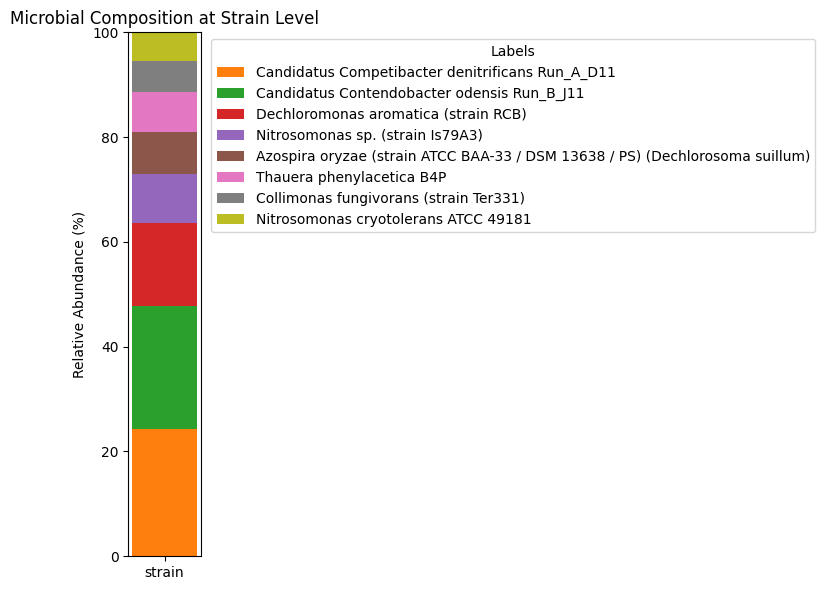

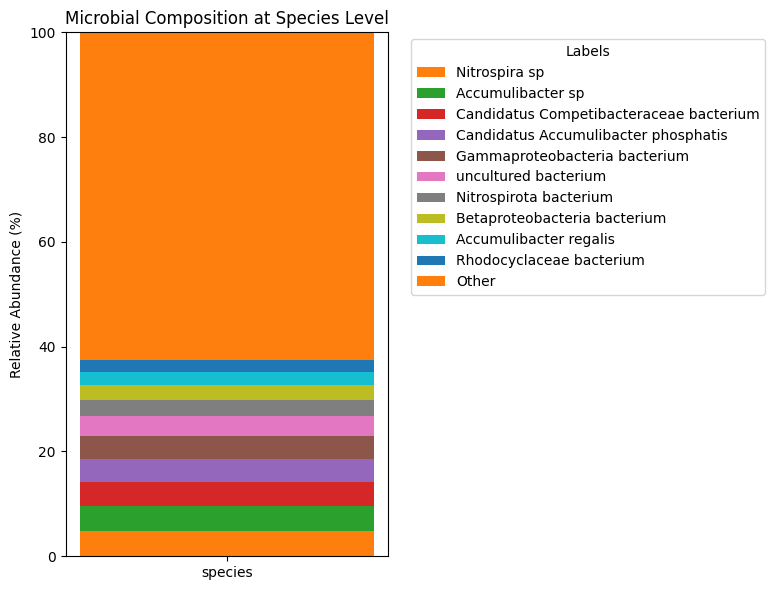

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your final annotated DIAMOND result with taxonomy ===
df_path = "Diamond_alignments/diamond_df_rank_annotated_fixed.csv"
df = pd.read_csv(df_path)

# === CONFIG ===
TOP_N = 10  # Number of most abundant taxa to label explicitly

def plot_composition(df, target_rank, top_n=10):
    """
    Generate a single stacked bar plot showing the relative abundance of peptides
    mapped to organisms at a specific taxonomic rank (e.g., 'species', 'strain').
    
    Parameters:
        df (pd.DataFrame): DataFrame containing peptide-organism mappings and taxonomy
        target_rank (str): Desired level of taxonomic resolution (e.g., 'strain', 'species')
        top_n (int): Number of most abundant taxa to display explicitly in legend
    """

    # === Filter data appropriately for each rank level ===
    df_copy = df.copy()
    
    if target_rank == "strain":
        # Include only peptides annotated to specific strains
        df_copy = df_copy[df_copy["taxonomy_rank"] == "strain"]
        df_copy = df_copy[df_copy["organism"].notna() & (df_copy["organism"] != "Unclassified")]
    else:
        # For species-level and others: allow all, including "Unclassified"
        df_copy["organism"] = df_copy["organism"].fillna("Unclassified").replace("NA", "Unclassified")

    # === Count peptide hits per organism and compute relative abundance ===
    counts = df_copy["organism"].value_counts()
    total = counts.sum()
    proportions = (counts / total * 100).sort_values(ascending=False)

    # === Keep top N most abundant organisms, group the rest under "Other" ===
    top_labels = proportions.head(top_n)
    others = proportions.iloc[top_n:]
    if not others.empty:
        top_labels["Other"] = others.sum()

    # === Plot single stacked bar ===
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar([target_rank], top_labels.values, bottom=0)

    bottom = 0
    for label, value in top_labels.items():
        # Each taxon contributes a portion of the stacked bar
        ax.bar(target_rank, value, bottom=bottom, label=label)
        bottom += value

    # === Final formatting ===
    ax.set_title(f"Microbial Composition at {target_rank.capitalize()} Level")
    ax.set_ylabel("Relative Abundance (%)")
    ax.set_ylim(0, 100)
    ax.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# === Run the function for both strain and species level ===
plot_composition(df, target_rank="strain", top_n=TOP_N)
plot_composition(df, target_rank="species", top_n=TOP_N)


### Step 13: Fetch Proteins from UniProtKB Based on Organism Rank Grouping (Alternative Strategy)

In this alternative strategy, we construct a custom protein database by selectively retrieving sequences from **UniProtKB** based on organisms identified through the DIAMOND alignment. Instead of downloading entire proteomes (as in the other strategy), we query UniProtKB for proteins associated with specific organism names, using fine-grained control over how many proteins are collected.

To ensure representativeness while maintaining control over database size, organisms are **grouped into rank tiers** based on their peptide hit frequency in the DIAMOND results:

| Rank Group        | Organism Index Range | Description                       | Protein Limit per Organism |
|-------------------|----------------------|------------------------------------|-----------------------------|
| Top 5             | 1st to 5th           | Dominant organisms in the sample  | High limits (e.g. 200k–250k)|
| Rank 6–10         | 6th to 10th          | Still highly represented          | Moderate limit (e.g. 100k)  |
| Rank 11–20        | 11th to 20th         | Mid-abundance organisms           | Medium limit (e.g. 50k)     |
| Rank 21–50        | 21st to 50th         | Lower-abundance but relevant      | Small limit (e.g. 20k)      |
| Rank 51+          | 51st and onward      | Rare organisms                    | Minimal limit (e.g. 5k)     |

For each rank tier, a **custom number of proteins** is fetched using UniProtKB’s REST API. The protein sequences are retrieved in chunks (maximum 500 per request) and appended into a FASTA file. This strategy allows us to build a balanced database that reflects the sample’s taxonomic profile while remaining computationally efficient.

This markdown block applies to **all subsequent UniProtKB collection cells**, which differ only in the group of organisms they fetch and the assigned limits.


In [ ]:
import os
import math
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# === 1. Configuration ===

# Generate a unique timestamp-based output folder for this run
session_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"Diamond_alignments/session_diamond_align_{session_time}"
os.makedirs(output_dir, exist_ok=True)

# Define output FASTA file where downloaded protein sequences will be saved
output_fasta_path = os.path.join(output_dir, "from_diamond_organisms_top5_custom_limits.fasta")

# === 2. Load the top 5 most frequent organisms that have at least `min_hits` peptide matches ===

df = pd.read_csv("Diamond_alignments/diamond_df_rank_annotated_fixed.csv")
organism_counts = df["organism"].value_counts()

# Filter organisms with enough confidence (min_hits threshold)
filtered_organisms = organism_counts[organism_counts >= min_hits]

# Select only the top 5 most frequent organisms
top_5_organisms = filtered_organisms.head(5).index.tolist()

# === 3. Define custom protein fetch limits per organism ===

# Allows fine control over how many proteins to fetch for each organism
custom_limits = {
    0: 250000,  # Highest priority organism
    1: 200000,
    2: 200000,
    3: 200000,
    4: 200000   # Fifth-ranked organism
}

# === 4. Get total number of UniProt entries for an organism ===

def get_total_results(organism):
    """
    Queries UniProtKB to determine the total number of available proteins for a given organism.
    Returns 0 if request fails.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": organism,
        "format": "json",
        "size": 1
    }
    try:
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        return int(r.headers.get("x-total-results", 0))
    except Exception as e:
        print(f"Failed to get total result count for {organism}: {e}")
        return 0

# === 5. Download protein sequences from UniProtKB in chunks ===

def fetch_uniprotkb_chunked_fasta(organism, limit):
    """
    Downloads up to `limit` protein sequences in FASTA format for the specified organism from UniProtKB.
    Uses 500-protein chunks due to API limits.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    chunk_size = 500
    headers = {"Accept": "text/x-fasta"}

    total_available = get_total_results(organism)
    if total_available == 0:
        return "", 0

    # Don't fetch more than what UniProt offers
    limit = min(limit, total_available)
    chunks = math.ceil(limit / chunk_size)

    print(f"\n🔍 Fetching proteins for: {organism} (available: {total_available}, fetching: {limit})")

    fetched = ""
    total_downloaded = 0

    # Loop through API in chunks
    for i in tqdm(range(chunks), desc=f"{organism[:40]}...", leave=True):
        offset = i * chunk_size
        params = {
            "query": organism,
            "format": "fasta",
            "size": chunk_size,
            "offset": offset,
            "compressed": "false"
        }
        try:
            r = requests.get(base_url, headers=headers, params=params)
            r.raise_for_status()
            chunk = r.text.strip()
            if not chunk:
                break
            fetched += chunk + "\n"
            total_downloaded += chunk.count(">")
        except Exception as e:
            print(f"Chunk {i+1} failed: {e}")
            break

    return fetched, total_downloaded

# === 6. Fetch and collect proteins for the top 5 organisms ===

all_entries = []
total_downloaded = 0

print("Starting UniProtKB protein fetch for top 5 organisms...")

for idx, organism in enumerate(top_5_organisms):
    limit = custom_limits.get(idx, 50000)  # Use default if not specified
    fasta, downloaded = fetch_uniprotkb_chunked_fasta(organism, limit)

    if fasta:
        all_entries.append(fasta.strip())
        total_downloaded += downloaded
        print(f"[{idx+1}] {organism}: {downloaded} proteins fetched")
    else:
        print(f"[{idx+1}] No proteins fetched for {organism}")

# === 7. Write combined results to a FASTA file ===

with open(output_fasta_path, "w") as f_out:
    f_out.write("\n".join(all_entries))

# === 8. Summary printout ===

print("\n=== SUMMARY ===")
print(f"Output FASTA: {output_fasta_path}")
print(f"Total protein sequences in database: {total_downloaded}")


🚀 Starting UniProtKB protein fetch for top 5 organisms...

🔍 Fetching proteins for: Nitrospira sp (available: 232037, fetching: 232037)


Nitrospira sp...: 100%|██████████| 465/465 [01:15<00:00,  6.15it/s]


✅ [1] Nitrospira sp: 232500 proteins fetched

🔍 Fetching proteins for: Accumulibacter sp (available: 51356, fetching: 51356)


Accumulibacter sp...: 100%|██████████| 103/103 [00:15<00:00,  6.57it/s]


✅ [2] Accumulibacter sp: 51500 proteins fetched

🔍 Fetching proteins for: Candidatus Competibacteraceae bacterium (available: 73152, fetching: 73152)


Candidatus Competibacteraceae bacterium...: 100%|██████████| 147/147 [00:20<00:00,  7.26it/s]


✅ [3] Candidatus Competibacteraceae bacterium: 73500 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter phosphatis (available: 21571, fetching: 21571)


Candidatus Accumulibacter phosphatis...: 100%|██████████| 44/44 [00:05<00:00,  7.54it/s]


✅ [4] Candidatus Accumulibacter phosphatis: 22000 proteins fetched

🔍 Fetching proteins for: Gammaproteobacteria bacterium (available: 3989693, fetching: 200000)


Gammaproteobacteria bacterium...: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]


✅ [5] Gammaproteobacteria bacterium: 200400 proteins fetched

📊 === SUMMARY ===
📁 Output FASTA: Diamond_alignments/session_diamond_align_2025-06-02_15-00-18\from_diamond_top5_15_hits_custom_limits.fasta
📦 Total protein sequences in database: 579900


In [ ]:
import os
import math
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# === 1. Configuration ===
limit_6_to_10 = 100000  # Define a fixed upper limit of proteins to collect for each organism ranked 6th to 10th

# Reuse the same session timestamp to store all output files consistently in the same directory
output_dir = f"Diamond_alignments/session_diamond_align_{session_time}"
os.makedirs(output_dir, exist_ok=True)

# Set the output file path for the FASTA file that will store the fetched protein sequences
output_fasta_path = os.path.join(output_dir, f"from_diamond_organisms_6_to_10.fasta")

# === 2. Load organisms ranked 6–10 with at least `min_hits` hits ===
# Load the annotated DIAMOND result file that includes organism names and their taxonomic ranks
df = pd.read_csv("Diamond_alignments/diamond_df_rank_annotated_fixed.csv")

# Count how many peptide hits were assigned to each organism
organism_counts = df["organism"].value_counts()

# Filter organisms to retain only those that had at least `min_hits` peptide hits
filtered_organisms = organism_counts[organism_counts >= min_hits]

# Select the 6th to 10th most frequent organisms (Python is 0-indexed, so [5:10] covers ranks 6–10)
organisms_6_10 = filtered_organisms[5:10].index.tolist()

# === 3. Fixed protein limit function ===
# This function is here for compatibility with the structure of earlier code blocks,
# in case limits need to be dynamic later. For now, it just returns a fixed value.
def get_protein_limit(_):
    return limit_6_to_10

# === 4. Get total number of UniProt results for an organism ===
# This helper function queries UniProtKB to determine how many protein entries are available for a given organism
def get_total_results(organism):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": organism,       # Free-text query on organism name
        "format": "json",
        "size": 1                # We only need the header to extract the total count
    }
    try:
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        return int(r.headers.get("x-total-results", 0))  # Total number of results returned in header
    except Exception as e:
        print(f"❌ Failed to get total result count for {organism}: {e}")
        return 0

# === 5. Fetch protein sequences in chunks ===
# This function retrieves protein sequences in FASTA format from UniProt in paginated chunks
def fetch_uniprotkb_chunked_fasta(organism, limit):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    chunk_size = 500  # Max allowed per UniProt API
    headers = {"Accept": "text/x-fasta"}

    # Determine how many results are available for this organism
    total_available = get_total_results(organism)
    if total_available == 0:
        return "", 0

    # Limit the number of downloads to either the user-defined limit or the total available proteins
    limit = min(limit, total_available)
    chunks = math.ceil(limit / chunk_size)  # Determine how many chunks we need

    print(f"\n🔍 Fetching proteins for: {organism} (available: {total_available}, fetching: {limit})")

    fetched = ""           # String to hold all concatenated FASTA results
    total_downloaded = 0   # Count how many protein sequences were downloaded

    for i in tqdm(range(chunks), desc=f"{organism[:40]}...", leave=True):
        offset = i * chunk_size
        params = {
            "query": organism,
            "format": "fasta",
            "size": chunk_size,
            "offset": offset,
            "compressed": "false"
        }
        try:
            r = requests.get(base_url, headers=headers, params=params)
            r.raise_for_status()
            chunk = r.text.strip()
            if not chunk:
                break
            fetched += chunk + "\n"
            total_downloaded += chunk.count(">")  # Count how many protein entries were retrieved
        except Exception as e:
            print(f"❌ Chunk {i+1} failed: {e}")
            break

    return fetched, total_downloaded

# === 6. Fetch and collect results ===
all_entries = []        # List to hold FASTA strings for all organisms
total_downloaded = 0    # Global counter for total number of sequences fetched

print("🚀 Starting UniProtKB protein fetch for organisms ranked 6-10...")

# Loop through the organisms ranked 6 to 10
for idx, organism in enumerate(organisms_6_10):
    limit = get_protein_limit(idx)  # Currently fixed for all (100k)
    fasta, downloaded = fetch_uniprotkb_chunked_fasta(organism, limit)

    if fasta:
        all_entries.append(fasta.strip())
        total_downloaded += downloaded
        print(f"✅ [{idx+6}] {organism}: {downloaded} proteins fetched")
    else:
        print(f"⚠️ [{idx+6}] No proteins fetched for {organism}")

# === 7. Save results ===
# Write all collected FASTA entries into one combined file for this tier
with open(output_fasta_path, "w") as f_out:
    f_out.write("\n".join(all_entries))

# === 8. Summary ===
print("\n📊 === SUMMARY ===")
print(f"📁 Output FASTA: {output_fasta_path}")
print(f"📦 Total protein sequences in database: {total_downloaded}")


🚀 Starting UniProtKB protein fetch for organisms ranked 6-20...

🔍 Fetching proteins for: uncultured bacterium (available: 941662, fetching: 100000)


uncultured bacterium...: 100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


✅ [6] uncultured bacterium: 100000 proteins fetched

🔍 Fetching proteins for: Nitrospirota bacterium (available: 407460, fetching: 100000)


Nitrospirota bacterium...: 100%|██████████| 200/200 [00:27<00:00,  7.22it/s]


✅ [7] Nitrospirota bacterium: 100000 proteins fetched

🔍 Fetching proteins for: Betaproteobacteria bacterium (available: 1936441, fetching: 100000)


Betaproteobacteria bacterium...: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


✅ [8] Betaproteobacteria bacterium: 100000 proteins fetched

🔍 Fetching proteins for: Accumulibacter regalis (available: 8473, fetching: 8473)


Accumulibacter regalis...: 100%|██████████| 17/17 [00:02<00:00,  7.42it/s]


✅ [9] Accumulibacter regalis: 8500 proteins fetched

🔍 Fetching proteins for: Rhodocyclaceae bacterium (available: 146202, fetching: 100000)


Rhodocyclaceae bacterium...: 100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


✅ [10] Rhodocyclaceae bacterium: 100000 proteins fetched

🔍 Fetching proteins for: Chloroflexota bacterium (available: 3522822, fetching: 50000)


Chloroflexota bacterium...: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


✅ [11] Chloroflexota bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Pseudomonadota bacterium (available: 10865642, fetching: 50000)


Pseudomonadota bacterium...: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


✅ [12] Pseudomonadota bacterium: 50100 proteins fetched

🔍 Fetching proteins for: Acidobacteriota bacterium (available: 1912444, fetching: 50000)


Acidobacteriota bacterium...: 100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


✅ [13] Acidobacteriota bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter appositus (available: 4265, fetching: 4265)


Candidatus Accumulibacter appositus...: 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


✅ [14] Candidatus Accumulibacter appositus: 4500 proteins fetched

🔍 Fetching proteins for: Anaerolineae bacterium (available: 773361, fetching: 50000)


Anaerolineae bacterium...: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


✅ [15] Anaerolineae bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Anaerolineales bacterium (available: 342982, fetching: 50000)


Anaerolineales bacterium...: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


✅ [16] Anaerolineales bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Deltaproteobacteria bacterium (available: 1539891, fetching: 50000)


Deltaproteobacteria bacterium...: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


✅ [17] Deltaproteobacteria bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Alphaproteobacteria bacterium (available: 4245541, fetching: 50000)


Alphaproteobacteria bacterium...: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


✅ [18] Alphaproteobacteria bacterium: 50000 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter aalborgensis (available: 4556, fetching: 4556)


Candidatus Accumulibacter aalborgensis...: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


✅ [19] Candidatus Accumulibacter aalborgensis: 5000 proteins fetched

🔍 Fetching proteins for: Paracoccaceae bacterium (available: 527692, fetching: 50000)


Paracoccaceae bacterium...: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


✅ [20] Paracoccaceae bacterium: 50000 proteins fetched

📊 === SUMMARY ===
📁 Output FASTA: Diamond_alignments/session_diamond_align_2025-06-02_15-00-18\from_diamond_organisms_6_to_20_splitlimits.fasta
📦 Total protein sequences in database: 818100


In [ ]:
import os
import math
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# === 1. Configuration ===
# Define how many proteins you want to retrieve per organism in this rank group (11–20)
limit_11_to_20 = 50000  # Can be tuned depending on database size, bandwidth, etc.

# Use the same timestamped session folder as previous downloads to keep things organized
output_dir = f"Diamond_alignments/session_diamond_align_{session_time}"
os.makedirs(output_dir, exist_ok=True)

# Define where to store the combined FASTA output for this rank group
output_fasta_path = os.path.join(output_dir, f"from_diamond_organisms_11_to_20.fasta")

# === 2. Load organisms ranked 11–20 with at least `min_hits` hits ===
# Load the annotated DIAMOND results from earlier in the pipeline
df = pd.read_csv("Diamond_alignments/diamond_df_rank_annotated_fixed.csv")

# Count number of hits (peptides matched) per organism
organism_counts = df["organism"].value_counts()

# Only retain organisms with sufficient evidence (≥ min_hits)
filtered_organisms = organism_counts[organism_counts >= min_hits]

# Select organisms ranked 11th through 20th (index 10 to 19 inclusive)
organisms_11_20 = filtered_organisms[10:20].index.tolist()

# === 3. Fixed protein limit function for this group
# This abstraction allows future flexibility (e.g. dynamic per-organism limits if needed)
def get_protein_limit(_):
    return limit_11_to_20

# === 4. Helper function to get total number of UniProtKB protein entries for a given organism
# This helps avoid requesting more than what is available from UniProt
def get_total_results(organism):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": organism,
        "format": "json",
        "size": 1  # We only need the header metadata for total count
    }
    try:
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        return int(r.headers.get("x-total-results", 0))  # Extract total result count from response header
    except Exception as e:
        print(f"❌ Failed to get total result count for {organism}: {e}")
        return 0

# === 5. Function to download protein sequences from UniProt in FASTA format using pagination
# Retrieves sequences in chunks to avoid server overload and manage large downloads
def fetch_uniprotkb_chunked_fasta(organism, limit):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    chunk_size = 500  # UniProt maximum per request
    headers = {"Accept": "text/x-fasta"}

    # Check how many entries are actually available for this organism
    total_available = get_total_results(organism)
    if total_available == 0:
        return "", 0

    # Adjust the requested limit to the number of available proteins if necessary
    limit = min(limit, total_available)
    chunks = math.ceil(limit / chunk_size)  # Determine how many requests we need

    print(f"\n🔍 Fetching proteins for: {organism} (available: {total_available}, fetching: {limit})")

    fetched = ""           # Will hold all FASTA content
    total_downloaded = 0   # Counter for number of protein sequences downloaded

    # Loop through and download the data in chunks
    for i in tqdm(range(chunks), desc=f"{organism[:40]}...", leave=True):
        offset = i * chunk_size
        params = {
            "query": organism,
            "format": "fasta",
            "size": chunk_size,
            "offset": offset,
            "compressed": "false"
        }
        try:
            r = requests.get(base_url, headers=headers, params=params)
            r.raise_for_status()
            chunk = r.text.strip()
            if not chunk:
                break  # Exit early if UniProt returns no content
            fetched += chunk + "\n"
            total_downloaded += chunk.count(">")  # Count the number of sequences by '>' headers
        except Exception as e:
            print(f"❌ Chunk {i+1} failed: {e}")
            break

    return fetched, total_downloaded

# === 6. Run fetch operation and collect all results ===
all_entries = []        # To store all FASTA content per organism
total_downloaded = 0    # Counter across all organisms in this rank group

print("🚀 Starting UniProtKB protein fetch for organisms ranked 11–20...")

# Loop through organisms 11th to 20th in order
for idx, organism in enumerate(organisms_11_20):
    limit = get_protein_limit(idx)
    fasta, downloaded = fetch_uniprotkb_chunked_fasta(organism, limit)

    if fasta:
        all_entries.append(fasta.strip())
        total_downloaded += downloaded
        print(f"✅ [{idx+11}] {organism}: {downloaded} proteins fetched")
    else:
        print(f"⚠️ [{idx+11}] No proteins fetched for {organism}")

# === 7. Save combined FASTA results ===
# Write all downloaded entries to a single file for this group
with open(output_fasta_path, "w") as f_out:
    f_out.write("\n".join(all_entries))

# === 8. Final summary output ===
print("\n📊 === SUMMARY ===")
print(f"📁 Output FASTA: {output_fasta_path}")
print(f"📦 Total protein sequences in database: {total_downloaded}")


In [ ]:
import os
import math
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# === 1. Configuration ===
# Define custom download limits for three sub-ranges:
limit_21_30 = 30000  # For organisms ranked 21st–30th
limit_31_40 = 20000  # For organisms ranked 31st–40th
limit_41_50 = 10000  # For organisms ranked 41st–50th

# Use the same session timestamp as earlier defined (assumes `session_time` is set in global context)
output_dir = f"Diamond_alignments/session_diamond_align_{session_time}"
os.makedirs(output_dir, exist_ok=True)

# Set path where final FASTA results for organisms 21–50 will be stored
output_fasta_path = os.path.join(output_dir, f"from_diamond_organisms_21_to_50_splitlimits.fasta")

# === 2. Load organisms ranked 21–50 with at least `min_hits` hits ===
# Load the DataFrame that includes taxonomy rank info
df = pd.read_csv("Diamond_alignments/diamond_df_rank_annotated_fixed.csv")

# Get the frequency count of peptide hits per organism
organism_counts = df["organism"].value_counts()

# Filter out organisms that don't meet the confidence threshold (`min_hits`)
filtered_organisms = organism_counts[organism_counts >= min_hits]

# Select organisms ranked 21st to 50th (i.e. slice index 20:50)
organisms_21_50 = filtered_organisms[20:50].index.tolist()

# === 3. Decide protein limit based on sub-rank tier ===
def get_protein_limit(relative_rank):
    """
    Determines how many proteins to fetch based on sub-rank of the organism:
    - Index 0–9 → rank 21–30
    - Index 10–19 → rank 31–40
    - Index 20–29 → rank 41–50
    """
    if relative_rank < 10:
        return limit_21_30
    elif relative_rank < 20:
        return limit_31_40
    else:
        return limit_41_50

# === 4. Get the total number of UniProt protein entries available for a given organism ===
def get_total_results(organism):
    """
    Uses UniProt's metadata header to check how many results exist for a given organism.
    This ensures we don't request more than what's available.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": organism,
        "format": "json",
        "size": 1  # Only one result needed to access metadata
    }
    try:
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        return int(r.headers.get("x-total-results", 0))
    except Exception as e:
        print(f"❌ Failed to get total result count for {organism}: {e}")
        return 0

# === 5. Fetch protein sequences in paginated chunks from UniProtKB ===
def fetch_uniprotkb_chunked_fasta(organism, limit):
    """
    Downloads protein sequences in FASTA format from UniProt, split across pages if needed.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    chunk_size = 500  # Max entries per API request
    headers = {"Accept": "text/x-fasta"}

    total_available = get_total_results(organism)
    if total_available == 0:
        return "", 0

    # Ensure we don’t fetch more than what’s available
    limit = min(limit, total_available)
    chunks = math.ceil(limit / chunk_size)

    print(f"\n🔍 Fetching proteins for: {organism} (available: {total_available}, fetching: {limit})")

    fetched = ""           # Will accumulate FASTA text
    total_downloaded = 0   # Count how many protein sequences were retrieved

    for i in tqdm(range(chunks), desc=f"{organism[:40]}...", leave=True):
        offset = i * chunk_size
        params = {
            "query": organism,
            "format": "fasta",
            "size": chunk_size,
            "offset": offset,
            "compressed": "false"
        }
        try:
            r = requests.get(base_url, headers=headers, params=params)
            r.raise_for_status()
            chunk = r.text.strip()
            if not chunk:
                break
            fetched += chunk + "\n"
            total_downloaded += chunk.count(">")  # Count number of FASTA entries
        except Exception as e:
            print(f"❌ Chunk {i+1} failed: {e}")
            break

    return fetched, total_downloaded

# === 6. Loop through all 30 organisms (ranks 21–50) and collect sequences ===
all_entries = []
total_downloaded = 0

print("🚀 Starting UniProtKB protein fetch for organisms ranked 21–50...")

# `enumerate` keeps track of relative rank (used for limit logic) and organism name
for idx, organism in enumerate(organisms_21_50):
    limit = get_protein_limit(idx)
    fasta, downloaded = fetch_uniprotkb_chunked_fasta(organism, limit)

    if fasta:
        all_entries.append(fasta.strip())
        total_downloaded += downloaded
        print(f"✅ [{idx+21}] {organism}: {downloaded} proteins fetched")
    else:
        print(f"⚠️ [{idx+21}] No proteins fetched for {organism}")

# === 7. Save combined FASTA file ===
with open(output_fasta_path, "w") as f_out:
    f_out.write("\n".join(all_entries))

# === 8. Summary Output ===
print("\n📊 === SUMMARY ===")
print(f"📁 Output FASTA: {output_fasta_path}")
print(f"📦 Total protein sequences in database: {total_downloaded}")


🚀 Starting UniProtKB protein fetch for organisms ranked 21–50...

🔍 Fetching proteins for: Candidatus Accumulibacter cognatus (available: 4322, fetching: 4322)


Candidatus Accumulibacter cognatus...: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


✅ [21] Candidatus Accumulibacter cognatus: 4500 proteins fetched

🔍 Fetching proteins for: Burkholderiales bacterium (available: 910548, fetching: 30000)


Burkholderiales bacterium...: 100%|██████████| 60/60 [01:48<00:00,  1.81s/it]


✅ [22] Burkholderiales bacterium: 30000 proteins fetched

🔍 Fetching proteins for: uncultured microorganism (available: 17209, fetching: 17209)


uncultured microorganism...: 100%|██████████| 35/35 [00:40<00:00,  1.14s/it]


✅ [23] uncultured microorganism: 17500 proteins fetched

🔍 Fetching proteins for: Nitrosomonas oligotropha (available: 8255, fetching: 8255)


Nitrosomonas oligotropha...: 100%|██████████| 17/17 [00:23<00:00,  1.36s/it]


✅ [24] Nitrosomonas oligotropha: 8500 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter proximus (available: 4538, fetching: 4538)


Candidatus Accumulibacter proximus...: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


✅ [25] Candidatus Accumulibacter proximus: 5000 proteins fetched

🔍 Fetching proteins for: Dechloromonas sp (available: 20280, fetching: 20280)


Dechloromonas sp...: 100%|██████████| 41/41 [00:51<00:00,  1.26s/it]


✅ [26] Dechloromonas sp: 20500 proteins fetched

🔍 Fetching proteins for: Burkholderiaceae bacterium (available: 245560, fetching: 30000)


Burkholderiaceae bacterium...: 100%|██████████| 60/60 [01:36<00:00,  1.60s/it]


✅ [27] Burkholderiaceae bacterium: 30000 proteins fetched

🔍 Fetching proteins for: Candidatus Dechloromonas phosphorivorans (available: 7439, fetching: 7439)


Candidatus Dechloromonas phosphorivorans...: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


✅ [28] Candidatus Dechloromonas phosphorivorans: 7500 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter affinis (available: 4127, fetching: 4127)


Candidatus Accumulibacter affinis...: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


✅ [29] Candidatus Accumulibacter affinis: 4500 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter sp. BA-94 (available: 3127, fetching: 3127)


Candidatus Accumulibacter sp. BA-94...: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


✅ [30] Candidatus Accumulibacter sp. BA-94: 3500 proteins fetched

🔍 Fetching proteins for: Verrucomicrobiota bacterium (available: 1472865, fetching: 20000)


Verrucomicrobiota bacterium...: 100%|██████████| 40/40 [01:14<00:00,  1.87s/it]


✅ [31] Verrucomicrobiota bacterium: 20000 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter vicinus (available: 4354, fetching: 4354)


Candidatus Accumulibacter vicinus...: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


✅ [32] Candidatus Accumulibacter vicinus: 4500 proteins fetched

🔍 Fetching proteins for: Nitrospira sp. ND1 (available: 4671, fetching: 4671)


Nitrospira sp. ND1...: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


✅ [33] Nitrospira sp. ND1: 5000 proteins fetched

🔍 Fetching proteins for: Lysobacteraceae bacterium (available: 101762, fetching: 20000)


Lysobacteraceae bacterium...: 100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


✅ [34] Lysobacteraceae bacterium: 20000 proteins fetched

🔍 Fetching proteins for: Nitrosomonas sp (available: 55671, fetching: 20000)


Nitrosomonas sp...: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


✅ [35] Nitrosomonas sp: 20000 proteins fetched

🔍 Fetching proteins for: Nitrospira defluvii (available: 4269, fetching: 4269)


Nitrospira defluvii...: 100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


✅ [36] Nitrospira defluvii: 4500 proteins fetched

🔍 Fetching proteins for: bacterium (available: 44506293, fetching: 20000)


bacterium...: 100%|██████████| 40/40 [02:53<00:00,  4.33s/it]


✅ [37] bacterium: 20000 proteins fetched

🔍 Fetching proteins for: Actinomycetes bacterium (available: 1769078, fetching: 20000)


Actinomycetes bacterium...: 100%|██████████| 40/40 [01:18<00:00,  1.96s/it]


✅ [38] Actinomycetes bacterium: 20000 proteins fetched

🔍 Fetching proteins for: Bacteroidota bacterium (available: 4875014, fetching: 20000)


Bacteroidota bacterium...: 100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


✅ [39] Bacteroidota bacterium: 20000 proteins fetched

🔍 Fetching proteins for: Propionivibrio sp (available: 6461, fetching: 6461)


Propionivibrio sp...: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]


✅ [40] Propionivibrio sp: 6500 proteins fetched

🔍 Fetching proteins for: marine metagenome (available: 1423689, fetching: 10000)


marine metagenome...: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


✅ [41] marine metagenome: 10000 proteins fetched

🔍 Fetching proteins for: Candidatus Accumulibacter adjunctus (available: 3906, fetching: 3906)


Candidatus Accumulibacter adjunctus...: 100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


✅ [42] Candidatus Accumulibacter adjunctus: 4000 proteins fetched

🔍 Fetching proteins for: Nitrosomonas ureae (available: 15272, fetching: 10000)


Nitrosomonas ureae...: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


✅ [43] Nitrosomonas ureae: 10000 proteins fetched

🔍 Fetching proteins for: Homo sapiens (Human) (available: 1670200, fetching: 10000)


Homo sapiens (Human)...: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


✅ [44] Homo sapiens (Human): 10020 proteins fetched

🔍 Fetching proteins for: Caldilineaceae bacterium (available: 146316, fetching: 10000)


Caldilineaceae bacterium...: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


✅ [45] Caldilineaceae bacterium: 10000 proteins fetched

🔍 Fetching proteins for: Azonexus sp (available: 9503, fetching: 9503)


Azonexus sp...: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


✅ [46] Azonexus sp: 10000 proteins fetched

🔍 Fetching proteins for: Planctomycetota bacterium (available: 2194054, fetching: 10000)


Planctomycetota bacterium...: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


✅ [47] Planctomycetota bacterium: 10000 proteins fetched

🔍 Fetching proteins for: Bacillota bacterium (Firmicutes bacterium) (available: 644160, fetching: 10000)


Bacillota bacterium (Firmicutes bacteriu...: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


✅ [48] Bacillota bacterium (Firmicutes bacterium): 10000 proteins fetched

🔍 Fetching proteins for: Gemmatimonadota bacterium (available: 800357, fetching: 10000)


Gemmatimonadota bacterium...: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


✅ [49] Gemmatimonadota bacterium: 10000 proteins fetched

🔍 Fetching proteins for: Candidatus Contendobacter sp (available: 4001, fetching: 4001)


Candidatus Contendobacter sp...: 100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


✅ [50] Candidatus Contendobacter sp: 4500 proteins fetched

📊 === SUMMARY ===
📁 Output FASTA: Diamond_alignments/session_diamond_align_2025-06-02_15-24-30\from_diamond_organisms_21_to_50_splitlimits.fasta
📦 Total protein sequences in database: 360520


In [ ]:
import os
import math
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# === 1. Configuration ===
# Set protein download limits depending on organism rank group
limit_51_100 = 3000    # For organisms ranked 51st to 100th
limit_101_plus = 1000  # For organisms ranked 101st and beyond

# Define the session-specific output directory
output_dir = f"Diamond_alignments/session_diamond_align_{session_time}"
os.makedirs(output_dir, exist_ok=True)

# Output FASTA file for storing all sequences from organisms ranked 51+
output_fasta_path = os.path.join(output_dir, f"from_diamond_organisms_51_plus_splitlimits.fasta")

# === 2. Load organisms ranked 51 and higher with enough peptide hits ===
df = pd.read_csv("Diamond_alignments/diamond_df_rank_annotated_fixed.csv")

# Count how many times each organism occurs (based on peptide matches)
organism_counts = df["organism"].value_counts()

# Keep only those organisms that passed the hit threshold
filtered_organisms = organism_counts[organism_counts >= min_hits]

# Slice organisms starting from the 51st position onwards
organisms_51_plus = filtered_organisms[50:].index.tolist()

# === 3. Assign per-organism protein download limit based on sub-rank ===
def get_protein_limit(relative_rank):
    """
    Determines the number of protein sequences to fetch for an organism.
    - Index 0–49 → rank 51–100 (use 3000 proteins)
    - Index 50+  → rank 101 and higher (use 1000 proteins)
    """
    if relative_rank < 50:
        return limit_51_100
    else:
        return limit_101_plus

# === 4. Determine how many protein entries are available on UniProt ===
def get_total_results(organism):
    """
    Returns the total number of UniProtKB entries for a given organism.
    This ensures we don't request more than actually exists.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": organism,
        "format": "json",
        "size": 1
    }
    try:
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        return int(r.headers.get("x-total-results", 0))
    except Exception as e:
        print(f"❌ Failed to get total result count for {organism}: {e}")
        return 0

# === 5. Fetch protein entries in paginated chunks ===
def fetch_uniprotkb_chunked_fasta(organism, limit):
    """
    Fetches protein entries from UniProt in FASTA format.
    Handles pagination to fetch large numbers of entries in manageable chunks.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    chunk_size = 500
    headers = {"Accept": "text/x-fasta"}

    total_available = get_total_results(organism)
    if total_available == 0:
        return "", 0

    limit = min(limit, total_available)
    chunks = math.ceil(limit / chunk_size)

    print(f"\n🔍 Fetching proteins for: {organism} (available: {total_available}, fetching: {limit})")

    fetched = ""           # Will store raw FASTA text
    total_downloaded = 0   # Counter for how many entries we retrieve

    for i in tqdm(range(chunks), desc=f"{organism[:40]}...", leave=True):
        offset = i * chunk_size
        params = {
            "query": organism,
            "format": "fasta",
            "size": chunk_size,
            "offset": offset,
            "compressed": "false"
        }
        try:
            r = requests.get(base_url, headers=headers, params=params)
            r.raise_for_status()
            chunk = r.text.strip()
            if not chunk:
                break
            fetched += chunk + "\n"
            total_downloaded += chunk.count(">")
        except Exception as e:
            print(f"❌ Chunk {i+1} failed: {e}")
            break

    return fetched, total_downloaded

# === 6. Loop through all organisms and collect sequences ===
all_entries = []
total_downloaded = 0
total_organisms = len(organisms_51_plus)

print(f"🚀 Starting UniProtKB protein fetch for {total_organisms} organisms ranked 51+")

for idx, organism in enumerate(organisms_51_plus):
    limit = get_protein_limit(idx)
    fasta, downloaded = fetch_uniprotkb_chunked_fasta(organism, limit)

    if fasta:
        all_entries.append(fasta.strip())
        total_downloaded += downloaded
        print(f"✅ [{idx+51}] {organism}: {downloaded} proteins fetched")
    else:
        print(f"⚠️ [{idx+51}] No proteins fetched for {organism}")

# === 7. Write all sequences to the output FASTA file ===
with open(output_fasta_path, "w") as f_out:
    f_out.write("\n".join(all_entries))

# === 8. Final Summary ===
print("\n📊 === SUMMARY ===")
print(f"📁 Output FASTA: {output_fasta_path}")
print(f"📦 Total protein sequences in database: {total_downloaded}")
print(f"🧬 Total organisms processed: {total_organisms}")


## FASTA Combination Step: Building the Final Custom Protein Database

This step consolidates all previously downloaded FASTA files—each representing proteins from different organism ranking groups—into a **single unified FASTA file**. This final protein database reflects the microbial community composition inferred from the DIAMOND alignment results and is used as a tailored search space for peptide-spectrum matching or functional annotation.

---

### Inputs

The FASTA files that are combined in this step were constructed in earlier steps by fetching proteins for organisms based on their peptide hit rank:

- `from_diamond_top5_custom_limits.fasta` — Proteins from the **top 5 ranked** organisms
- `from_diamond_organisms_6_to_10.fasta` — Proteins from organisms ranked **6–10**
- `from_diamond_organisms_11_to_20.fasta` — Proteins from organisms ranked **11–20**
- `from_diamond_organisms_21_to_50_splitlimits.fasta` — Proteins from organisms ranked **21–50**
- `from_diamond_organisms_51_plus_splitlimits.fasta` — Proteins from organisms ranked **51 and beyond**

---

### Process Summary

- Each FASTA file is opened and read.
- Protein entries are **normalized and reformatted** to ensure proper FASTA formatting (i.e., prefixed with `>`).
- Files that are missing or empty are **automatically skipped**.
- All valid protein entries are concatenated and saved into a single output file.

---

### Output

- A unified file named:  
  `all_diamond_proteins_combined_{min_hits}_hits.fasta`  
- This FASTA serves as the **final custom protein database** used for:
  - Spectrum identification
  - Protein annotation
  - Functional inference
  - Database reduction/clustering steps


In [ ]:
import os

# === 1. File paths ===
# Define the session directory based on previous session time variable
session_folder = f"Diamond_alignments/session_diamond_align_{session_time}"

# Define paths to each partial FASTA file created in previous steps
top5_fasta = os.path.join(session_folder, "from_diamond_top5_custom_limits")
middle5to10_fasta = os.path.join(session_folder, "from_diamond_organisms_6_to_10.fasta")
middle11to20_fasta = os.path.join(session_folder, "from_diamond_organisms_11_to_20.fasta")
middle21to50_fasta = os.path.join(session_folder, "from_diamond_organisms_21_to_50_splitlimits.fasta")
remaining_fasta = os.path.join(session_folder, "from_diamond_organisms_51_plus_splitlimits.fasta")

# Output file: final combined FASTA file with all proteins
combined_fasta = os.path.join(session_folder, f"all_diamond_proteins_combined_{min_hits}_hits.fasta")

# === 2. Merge all FASTA files ===
# List all input files to loop through them
input_files = [top5_fasta, middle5to10_fasta, middle11to20_fasta, middle21to50_fasta, remaining_fasta]
total_entries = 0  # Counter for total number of protein entries added

# Open the final combined FASTA file for writing
with open(combined_fasta, "w") as out_f:
    for file_path in input_files:
        # Skip files that are missing (e.g., not generated due to lack of matches)
        if not os.path.exists(file_path):
            print(f"Skipping missing file: {file_path}")
            continue

        # Read and process the FASTA contents
        with open(file_path, "r") as f_in:
            content = f_in.read().strip()

            # Skip empty files
            if not content:
                continue

            # Split into individual protein entries (FASTA format)
            entries = content.split("\n>")

            for i, entry in enumerate(entries):
                # Ensure every entry begins with a '>' symbol
                if not entry.startswith(">"):
                    entry = ">" + entry

                # Write cleaned entry to output FASTA
                out_f.write(entry.strip() + "\n")
                total_entries += 1  # Increment global counter

# === 3. Final Summary ===
# Inform the user that the combined database has been created
print("\nCombined protein FASTA created.")
print(f"Output FASTA: {combined_fasta}")
print(f"Total protein entries in combined database: {total_entries}")


In [18]:
import pandas as pd
import os
import requests
from tqdm import tqdm

# === 1. FASTA download function ===
def download_fasta(proteome_id):
    url = f"https://rest.uniprot.org/uniprotkb/stream?query=proteome:{proteome_id}&format=fasta"
    try:
        response = requests.get(url)
        if response.ok and response.text.strip():
            return response.text
    except:
        pass
    return None

# === 2. Paths ===
proteome_csv_path = r"Diamond_alignments/session_diamond_align_2025-05-31_15-40-56/diamond_proteome_matches_remaining.csv"
output_dir = os.path.dirname(proteome_csv_path)

fasta_filename = "diamond_proteins_remaining_proteomes.fasta"
combined_fasta_path = os.path.join(output_dir, fasta_filename)

# === 3. Load proteome IDs ===
df = pd.read_csv(proteome_csv_path)
valid_df = df[df["Proteome ID"].notna()]
proteome_ids = valid_df["Proteome ID"].unique()

# === 4. Download all proteins (no deduplication) ===
all_entries = []
total_downloaded = 0

print("\n📦 Starting full protein download (no deduplication)...")

for upid in tqdm(proteome_ids):
    fasta = download_fasta(upid)
    if not fasta:
        print(f"❌ Failed to download {upid}")
        continue

    proteins = fasta.strip().split("\n>")
    for i, entry in enumerate(proteins):
        if not entry.startswith(">"):
            entry = ">" + entry
        all_entries.append(entry)

    print(f"✅ {upid}: {len(proteins)} proteins parsed")
    total_downloaded += len(proteins)

# === 5. Save all entries ===
with open(combined_fasta_path, "w") as out_f:
    out_f.write("\n".join(all_entries))

# === 6. Summary ===
print(f"\n🎯 Combined database saved to: {combined_fasta_path}")
print(f"🧬 Total proteins in database (no deduplication): {total_downloaded}")



📦 Starting full protein download (no deduplication)...


  0%|          | 1/237 [00:06<26:22,  6.71s/it]

✅ UP000021315: 3953 proteins parsed


  1%|          | 2/237 [00:15<32:05,  8.19s/it]

✅ UP000664003: 3702 proteins parsed


  1%|▏         | 3/237 [00:23<30:00,  7.69s/it]

✅ UP000198814: 3170 proteins parsed


  2%|▏         | 4/237 [00:32<32:25,  8.35s/it]

✅ UP000697998: 4538 proteins parsed


  2%|▏         | 5/237 [00:38<28:29,  7.37s/it]

✅ UP000509529: 2873 proteins parsed


  3%|▎         | 6/237 [00:42<24:00,  6.23s/it]

✅ UP000510879: 2571 proteins parsed


  3%|▎         | 7/237 [00:49<25:47,  6.73s/it]

✅ UP000739411: 3814 proteins parsed


  3%|▎         | 8/237 [00:57<26:32,  6.96s/it]

✅ UP000706151: 4127 proteins parsed


  4%|▍         | 9/237 [01:02<24:15,  6.39s/it]

✅ UP000020878: 3127 proteins parsed


  4%|▍         | 10/237 [01:06<21:54,  5.79s/it]

✅ UP000033046: 2622 proteins parsed


  5%|▍         | 11/237 [01:13<23:16,  6.18s/it]

✅ UP000019812: 4354 proteins parsed


  5%|▌         | 12/237 [01:22<25:53,  6.90s/it]

✅ UP000192075: 4586 proteins parsed


  5%|▌         | 13/237 [01:27<24:11,  6.48s/it]

✅ UP000292226: 3169 proteins parsed


  6%|▌         | 14/237 [01:32<21:59,  5.92s/it]

✅ UP000001629: 2841 proteins parsed


  6%|▋         | 15/237 [01:39<22:50,  6.17s/it]

✅ UP000001660: 4263 proteins parsed


  7%|▋         | 16/237 [01:49<26:59,  7.33s/it]

✅ UP000293802: 5998 proteins parsed


  7%|▋         | 17/237 [01:53<23:02,  6.28s/it]

✅ UP000035517: 2299 proteins parsed


  8%|▊         | 18/237 [02:00<23:34,  6.46s/it]

✅ UP000509427: 4173 proteins parsed


  8%|▊         | 19/237 [02:05<22:28,  6.19s/it]

✅ UP000702847: 2957 proteins parsed


  8%|▊         | 20/237 [02:12<23:36,  6.53s/it]

✅ UP000020218: 3906 proteins parsed


  9%|▉         | 21/237 [02:18<22:21,  6.21s/it]

✅ UP000181998: 3133 proteins parsed


  9%|▉         | 22/237 [04:32<2:39:35, 44.54s/it]

✅ UP000005640: 83374 proteins parsed


 10%|▉         | 23/237 [04:40<1:59:31, 33.51s/it]

✅ UP000674002: 4743 proteins parsed


 10%|█         | 24/237 [04:44<1:27:58, 24.78s/it]

✅ UP000672756: 2893 proteins parsed


 11%|█         | 25/237 [04:55<1:12:36, 20.55s/it]

✅ UP000315010: 7247 proteins parsed


 11%|█         | 26/237 [04:59<54:54, 15.62s/it]  

✅ UP000681864: 2157 proteins parsed


 11%|█▏        | 27/237 [05:01<40:52, 11.68s/it]

✅ UP000221516: 1751 proteins parsed


 12%|█▏        | 28/237 [05:08<35:30, 10.19s/it]

✅ UP000439117: 3999 proteins parsed


 12%|█▏        | 29/237 [05:11<27:58,  8.07s/it]

✅ UP000222210: 1320 proteins parsed


 13%|█▎        | 30/237 [05:19<27:06,  7.86s/it]

✅ UP000035760: 4014 proteins parsed


 13%|█▎        | 31/237 [05:26<26:57,  7.85s/it]

✅ UP000199600: 3621 proteins parsed


 14%|█▎        | 32/237 [05:35<27:26,  8.03s/it]

✅ UP000019184: 4763 proteins parsed


 14%|█▍        | 33/237 [05:43<27:46,  8.17s/it]

✅ UP000020226: 4767 proteins parsed


 14%|█▍        | 34/237 [05:50<26:25,  7.81s/it]

✅ UP000318368: 3738 proteins parsed


 15%|█▍        | 35/237 [05:57<25:03,  7.44s/it]

✅ UP000253831: 3943 proteins parsed


 15%|█▌        | 36/237 [06:03<23:27,  7.00s/it]

✅ UP000664181: 2725 proteins parsed


 16%|█▌        | 37/237 [06:08<21:59,  6.60s/it]

✅ UP000676034: 3047 proteins parsed


 16%|█▌        | 38/237 [06:17<23:35,  7.11s/it]

✅ UP000247367: 4330 proteins parsed


 16%|█▋        | 39/237 [06:23<22:37,  6.86s/it]

✅ UP000501891: 3265 proteins parsed


 17%|█▋        | 40/237 [06:26<18:43,  5.70s/it]

✅ UP000678867: 1182 proteins parsed


 17%|█▋        | 41/237 [08:18<2:02:20, 37.45s/it]

✅ UP000002277: 48769 proteins parsed


 18%|█▊        | 42/237 [08:22<1:29:41, 27.60s/it]

✅ UP000000429: 1554 proteins parsed


 18%|█▊        | 43/237 [08:40<1:19:27, 24.58s/it]

✅ UP000018524: 7026 proteins parsed


 19%|█▊        | 44/237 [08:49<1:04:00, 19.90s/it]

✅ UP000679647: 3214 proteins parsed


 19%|█▉        | 45/237 [09:04<59:38, 18.64s/it]  

✅ UP000291769: 7151 proteins parsed


 19%|█▉        | 46/237 [09:12<48:51, 15.35s/it]

✅ UP000641280: 3875 proteins parsed


 20%|█▉        | 47/237 [09:21<42:39, 13.47s/it]

✅ UP000315748: 4285 proteins parsed


 20%|██        | 48/237 [09:28<35:59, 11.42s/it]

✅ UP000678872: 2809 proteins parsed


 21%|██        | 49/237 [09:33<29:54,  9.54s/it]

✅ UP000237592: 1970 proteins parsed


 21%|██        | 50/237 [09:47<34:14, 10.99s/it]

✅ UP000438537: 7065 proteins parsed


 22%|██▏       | 51/237 [09:57<32:27, 10.47s/it]

✅ UP000226672: 5177 proteins parsed


 22%|██▏       | 52/237 [10:09<33:50, 10.98s/it]

✅ UP000199005: 4809 proteins parsed


 22%|██▏       | 53/237 [10:17<30:49, 10.05s/it]

✅ UP000718281: 2924 proteins parsed


 23%|██▎       | 54/237 [10:23<26:48,  8.79s/it]

✅ UP001147470: 3043 proteins parsed


 23%|██▎       | 55/237 [10:30<25:13,  8.32s/it]

✅ UP000663379: 3243 proteins parsed


 24%|██▎       | 56/237 [10:40<27:08,  9.00s/it]

✅ UP000478367: 4822 proteins parsed


 24%|██▍       | 57/237 [10:48<25:44,  8.58s/it]

✅ UP000293149: 3060 proteins parsed


 24%|██▍       | 58/237 [10:51<20:18,  6.81s/it]

✅ UP000054262: 1336 proteins parsed


 25%|██▍       | 59/237 [11:04<25:38,  8.64s/it]

✅ UP000221358: 6021 proteins parsed


 25%|██▌       | 60/237 [11:12<25:32,  8.66s/it]

✅ UP000587070: 3536 proteins parsed


 26%|██▌       | 61/237 [11:20<24:50,  8.47s/it]

✅ UP000236646: 3591 proteins parsed


 26%|██▌       | 62/237 [11:27<23:29,  8.05s/it]

✅ UP000552234: 3458 proteins parsed


 27%|██▋       | 63/237 [11:35<23:21,  8.06s/it]

✅ UP000886602: 3924 proteins parsed


 27%|██▋       | 64/237 [11:43<23:14,  8.06s/it]

✅ UP000664716: 3155 proteins parsed


 27%|██▋       | 65/237 [11:46<18:30,  6.45s/it]

✅ UP000257775: 1696 proteins parsed


 28%|██▊       | 66/237 [11:56<20:54,  7.34s/it]

✅ UP000028843: 4034 proteins parsed


 28%|██▊       | 67/237 [12:05<22:26,  7.92s/it]

✅ UP000248168: 3885 proteins parsed


 29%|██▊       | 68/237 [12:09<19:15,  6.84s/it]

✅ UP001064802: 1110 proteins parsed


 29%|██▉       | 69/237 [12:17<19:55,  7.12s/it]

✅ UP000251502: 3381 proteins parsed


 30%|██▉       | 70/237 [12:22<18:31,  6.66s/it]

✅ UP000002718: 2732 proteins parsed


 30%|██▉       | 71/237 [12:32<20:31,  7.42s/it]

✅ UP000069205: 4733 proteins parsed


 30%|███       | 72/237 [12:41<22:05,  8.03s/it]

✅ UP000664142: 3884 proteins parsed


 31%|███       | 73/237 [12:48<20:42,  7.58s/it]

✅ UP000245904: 2171 proteins parsed


 31%|███       | 74/237 [12:52<17:50,  6.57s/it]

✅ UP000681244: 1857 proteins parsed


 32%|███▏      | 75/237 [12:59<18:09,  6.73s/it]

✅ UP000471295: 2903 proteins parsed


 32%|███▏      | 76/237 [13:00<13:27,  5.02s/it]

✅ UP000002332: 474 proteins parsed


 32%|███▏      | 77/237 [13:20<25:19,  9.50s/it]

✅ UP000002139: 9320 proteins parsed


 33%|███▎      | 78/237 [13:26<22:20,  8.43s/it]

✅ UP000681387: 2380 proteins parsed


 33%|███▎      | 79/237 [15:26<1:50:12, 41.85s/it]

✅ UP000008227: 45672 proteins parsed


 34%|███▍      | 80/237 [15:34<1:22:47, 31.64s/it]

✅ UP000352687: 4056 proteins parsed


 34%|███▍      | 81/237 [15:41<1:03:45, 24.52s/it]

✅ UP000233252: 4350 proteins parsed


 35%|███▍      | 82/237 [15:51<51:37, 19.98s/it]  

✅ UP000316082: 4315 proteins parsed


 35%|███▌      | 83/237 [15:59<41:57, 16.35s/it]

✅ UP000292155: 4276 proteins parsed


 35%|███▌      | 84/237 [16:02<31:44, 12.45s/it]

✅ UP000678472: 1846 proteins parsed


 36%|███▌      | 85/237 [16:06<25:01,  9.88s/it]

✅ UP000221897: 2397 proteins parsed


 36%|███▋      | 86/237 [16:12<22:18,  8.86s/it]

✅ UP000715424: 3301 proteins parsed


 37%|███▋      | 87/237 [16:19<20:43,  8.29s/it]

✅ UP000253117: 3729 proteins parsed


 37%|███▋      | 88/237 [16:26<19:40,  7.92s/it]

✅ UP000306734: 3405 proteins parsed


 38%|███▊      | 89/237 [16:35<19:52,  8.06s/it]

✅ UP000226579: 3934 proteins parsed


 38%|███▊      | 90/237 [16:43<19:46,  8.07s/it]

✅ UP000501139: 4311 proteins parsed


 38%|███▊      | 91/237 [16:50<19:05,  7.84s/it]

✅ UP000070186: 3886 proteins parsed


 39%|███▉      | 92/237 [16:54<16:08,  6.68s/it]

✅ UP000318813: 1705 proteins parsed


 39%|███▉      | 93/237 [17:00<15:40,  6.53s/it]

✅ UP000886689: 2884 proteins parsed


 40%|███▉      | 94/237 [17:14<20:40,  8.67s/it]

✅ UP000051195: 5611 proteins parsed


 40%|████      | 95/237 [17:20<18:41,  7.90s/it]

✅ UP000510829: 3064 proteins parsed


 41%|████      | 96/237 [17:29<19:11,  8.17s/it]

✅ UP000198736: 4434 proteins parsed


 41%|████      | 97/237 [17:33<16:16,  6.97s/it]

✅ UP000681675: 1778 proteins parsed


 41%|████▏     | 98/237 [17:43<17:54,  7.73s/it]

✅ UP000807785: 4148 proteins parsed


 42%|████▏     | 99/237 [17:48<16:15,  7.07s/it]

✅ UP000192779: 4107 proteins parsed


 42%|████▏     | 100/237 [17:53<14:18,  6.26s/it]

✅ UP000655701: 2313 proteins parsed


 43%|████▎     | 101/237 [17:55<11:25,  5.04s/it]

✅ UP000228720: 1245 proteins parsed


 43%|████▎     | 102/237 [18:03<13:12,  5.87s/it]

✅ UP000765620: 4849 proteins parsed


 43%|████▎     | 103/237 [18:11<15:09,  6.79s/it]

✅ UP000318422: 3918 proteins parsed


 44%|████▍     | 104/237 [18:17<14:29,  6.53s/it]

✅ UP000198612: 2844 proteins parsed


 44%|████▍     | 105/237 [18:24<14:08,  6.43s/it]

✅ UP000593737: 4147 proteins parsed


 45%|████▍     | 106/237 [18:28<12:38,  5.79s/it]

✅ UP001177579: 2655 proteins parsed


 45%|████▌     | 107/237 [18:35<13:11,  6.09s/it]

✅ UP000192740: 3845 proteins parsed


 46%|████▌     | 108/237 [19:38<49:55, 23.22s/it]

✅ UP000694564: 33006 proteins parsed


 46%|████▌     | 109/237 [19:40<36:09, 16.95s/it]

✅ UP000095024: 1559 proteins parsed


 46%|████▋     | 110/237 [19:46<29:05, 13.74s/it]

✅ UP000270626: 3285 proteins parsed


 47%|████▋     | 111/237 [19:54<24:50, 11.83s/it]

✅ UP000233586: 4082 proteins parsed


 47%|████▋     | 112/237 [19:59<20:38,  9.91s/it]

✅ UP000031969: 2930 proteins parsed


 48%|████▊     | 113/237 [20:07<19:22,  9.38s/it]

✅ UP000319502: 4098 proteins parsed


 48%|████▊     | 114/237 [20:15<18:19,  8.94s/it]

✅ UP000192042: 4147 proteins parsed


 49%|████▊     | 115/237 [20:21<16:23,  8.06s/it]

✅ UP000244972: 3413 proteins parsed


 49%|████▉     | 116/237 [20:28<15:24,  7.64s/it]

✅ UP000678348: 2755 proteins parsed


 49%|████▉     | 117/237 [20:31<12:22,  6.19s/it]

✅ UP000668061: 1015 proteins parsed


 50%|████▉     | 118/237 [20:38<13:01,  6.57s/it]

✅ UP000241912: 3283 proteins parsed


 50%|█████     | 119/237 [20:46<13:37,  6.93s/it]

✅ UP000265961: 4376 proteins parsed


 51%|█████     | 120/237 [20:52<12:41,  6.50s/it]

✅ UP000192864: 2533 proteins parsed


 51%|█████     | 121/237 [20:56<11:16,  5.83s/it]

✅ UP000675882: 2174 proteins parsed


 51%|█████▏    | 122/237 [20:59<09:25,  4.92s/it]

✅ UP000218611: 1543 proteins parsed


 52%|█████▏    | 123/237 [21:02<08:29,  4.47s/it]

✅ UP000217535: 2170 proteins parsed


 52%|█████▏    | 124/237 [21:07<08:45,  4.65s/it]

✅ UP000257259: 3011 proteins parsed


 53%|█████▎    | 125/237 [21:12<08:41,  4.66s/it]

✅ UP000234782: 3279 proteins parsed


 53%|█████▎    | 126/237 [21:21<11:08,  6.02s/it]

✅ UP001179121: 4561 proteins parsed


 54%|█████▎    | 127/237 [21:28<11:28,  6.26s/it]

✅ UP000198607: 4057 proteins parsed


 54%|█████▍    | 128/237 [21:33<10:56,  6.03s/it]

✅ UP000187526: 3392 proteins parsed


 54%|█████▍    | 129/237 [21:37<09:24,  5.23s/it]

✅ UP000237298: 2035 proteins parsed


 55%|█████▍    | 130/237 [21:43<09:49,  5.51s/it]

✅ UP000432822: 3554 proteins parsed


 55%|█████▌    | 131/237 [21:50<10:49,  6.12s/it]

✅ UP000013140: 4268 proteins parsed


 56%|█████▌    | 132/237 [21:54<09:29,  5.42s/it]

✅ UP000063254: 2804 proteins parsed


 56%|█████▌    | 133/237 [23:14<48:12, 27.81s/it]

✅ UP000001519: 44723 proteins parsed


 57%|█████▋    | 134/237 [23:21<37:06, 21.62s/it]

✅ UP000002186: 3927 proteins parsed


 57%|█████▋    | 135/237 [23:26<28:16, 16.63s/it]

✅ UP000683141: 2617 proteins parsed


 57%|█████▋    | 136/237 [23:32<22:38, 13.45s/it]

✅ UP000291219: 4191 proteins parsed


 58%|█████▊    | 137/237 [23:42<20:23, 12.24s/it]

✅ UP000013047: 4836 proteins parsed


 58%|█████▊    | 138/237 [23:46<16:16,  9.87s/it]

✅ UP000178516: 2322 proteins parsed


 59%|█████▊    | 139/237 [23:54<15:18,  9.37s/it]

✅ UP000292783: 4688 proteins parsed


 59%|█████▉    | 140/237 [24:06<16:25, 10.16s/it]

✅ UP000245990: 6454 proteins parsed


 59%|█████▉    | 141/237 [24:13<14:33,  9.10s/it]

✅ UP000248024: 3167 proteins parsed


 60%|█████▉    | 142/237 [24:20<13:32,  8.55s/it]

✅ UP000468742: 5656 proteins parsed


 60%|██████    | 143/237 [24:22<10:15,  6.55s/it]

✅ UP000557613: 1047 proteins parsed


 61%|██████    | 144/237 [24:30<10:36,  6.84s/it]

✅ UP000580043: 5080 proteins parsed


 61%|██████    | 145/237 [24:36<10:10,  6.63s/it]

✅ UP000267650: 3260 proteins parsed


 62%|██████▏   | 146/237 [24:41<09:34,  6.31s/it]

✅ UP000192473: 3502 proteins parsed


 62%|██████▏   | 147/237 [24:48<09:39,  6.44s/it]

✅ UP000473322: 3762 proteins parsed


 62%|██████▏   | 148/237 [24:53<09:04,  6.11s/it]

✅ UP000199102: 3014 proteins parsed


 63%|██████▎   | 149/237 [24:54<06:42,  4.58s/it]

✅ UP000326137: 274 proteins parsed


 64%|██████▎   | 151/237 [24:59<04:36,  3.22s/it]

✅ UP000012063: 2662 proteins parsed
✅ UP000288884: 7 proteins parsed


 64%|██████▍   | 152/237 [25:03<05:01,  3.55s/it]

✅ UP000297111: 1743 proteins parsed


 65%|██████▍   | 153/237 [25:09<05:51,  4.18s/it]

✅ UP000196124: 2923 proteins parsed


 65%|██████▍   | 154/237 [25:17<07:19,  5.30s/it]

✅ UP000437123: 4942 proteins parsed


 65%|██████▌   | 155/237 [25:23<07:36,  5.57s/it]

✅ UP000316214: 4239 proteins parsed


 66%|██████▌   | 156/237 [26:22<29:05, 21.55s/it]

✅ UP000515126: 38135 proteins parsed


 66%|██████▌   | 157/237 [26:28<22:35, 16.95s/it]

✅ UP000227043: 4097 proteins parsed


 67%|██████▋   | 158/237 [26:33<17:24, 13.22s/it]

✅ UP000678406: 3052 proteins parsed


 67%|██████▋   | 159/237 [26:39<14:22, 11.05s/it]

✅ UP000321694: 3798 proteins parsed


 68%|██████▊   | 160/237 [26:47<12:58, 10.11s/it]

✅ UP000199032: 4245 proteins parsed


 68%|██████▊   | 161/237 [26:52<11:10,  8.82s/it]

✅ UP000028638: 4116 proteins parsed


 68%|██████▊   | 162/237 [26:57<09:24,  7.52s/it]

✅ UP000192458: 2803 proteins parsed


 69%|██████▉   | 163/237 [27:04<09:03,  7.34s/it]

✅ UP000244930: 4055 proteins parsed


 69%|██████▉   | 164/237 [28:49<44:45, 36.78s/it]

✅ UP000006718: 44389 proteins parsed


 70%|██████▉   | 165/237 [28:59<34:14, 28.53s/it]

✅ UP000389128: 4972 proteins parsed


 70%|███████   | 166/237 [29:03<25:10, 21.28s/it]

✅ UP000226507: 2643 proteins parsed


 70%|███████   | 167/237 [29:10<19:59, 17.13s/it]

✅ UP000074561: 5385 proteins parsed


 71%|███████   | 168/237 [29:18<16:32, 14.38s/it]

✅ UP000317813: 4839 proteins parsed


 71%|███████▏  | 169/237 [29:27<14:18, 12.63s/it]

✅ UP000199533: 3744 proteins parsed


 72%|███████▏  | 170/237 [29:33<12:03, 10.79s/it]

✅ UP000485501: 3523 proteins parsed


 72%|███████▏  | 171/237 [29:36<09:13,  8.39s/it]

✅ UP000009077: 1922 proteins parsed


 73%|███████▎  | 172/237 [29:38<07:02,  6.50s/it]

✅ UP000232361: 1480 proteins parsed


 73%|███████▎  | 173/237 [29:45<06:54,  6.47s/it]

✅ UP000233401: 3232 proteins parsed


 73%|███████▎  | 174/237 [29:51<06:50,  6.52s/it]

✅ UP000683229: 3137 proteins parsed


 74%|███████▍  | 175/237 [29:56<06:05,  5.90s/it]

✅ UP000298402: 1991 proteins parsed


 74%|███████▍  | 176/237 [30:06<07:13,  7.10s/it]

✅ UP000008392: 4429 proteins parsed


 75%|███████▍  | 177/237 [30:11<06:42,  6.71s/it]

✅ UP000430327: 2993 proteins parsed


 75%|███████▌  | 178/237 [30:17<06:23,  6.50s/it]

✅ UP000036902: 3723 proteins parsed


 76%|███████▌  | 179/237 [30:23<06:01,  6.24s/it]

✅ UP000226925: 3703 proteins parsed


 76%|███████▌  | 180/237 [30:28<05:25,  5.71s/it]

✅ UP000718593: 3147 proteins parsed


 76%|███████▋  | 181/237 [30:34<05:36,  6.01s/it]

✅ UP000233557: 3699 proteins parsed


 77%|███████▋  | 182/237 [30:39<05:17,  5.77s/it]

✅ UP000259012: 3738 proteins parsed


 77%|███████▋  | 183/237 [30:43<04:35,  5.10s/it]

✅ UP000234749: 2968 proteins parsed


 78%|███████▊  | 184/237 [30:47<04:12,  4.76s/it]

✅ UP000221591: 2310 proteins parsed


 78%|███████▊  | 186/237 [30:59<04:06,  4.83s/it]

✅ UP000035170: 6788 proteins parsed
❌ Failed to download UP001197729


 79%|███████▉  | 187/237 [32:30<25:37, 30.75s/it]

✅ UP000233100: 50205 proteins parsed


 79%|███████▉  | 188/237 [32:39<19:40, 24.08s/it]

✅ UP000324880: 5345 proteins parsed


 80%|███████▉  | 189/237 [32:46<15:10, 18.96s/it]

✅ UP000663444: 3712 proteins parsed


 80%|████████  | 190/237 [32:52<11:57, 15.26s/it]

✅ UP000066284: 3371 proteins parsed


 81%|████████  | 191/237 [32:56<09:09, 11.94s/it]

✅ UP000244244: 3203 proteins parsed


 81%|████████  | 192/237 [33:01<07:25,  9.90s/it]

✅ UP000183249: 2594 proteins parsed


 81%|████████▏ | 193/237 [33:12<07:20, 10.02s/it]

✅ UP000198887: 5040 proteins parsed


 82%|████████▏ | 194/237 [33:22<07:13, 10.07s/it]

✅ UP000198674: 4740 proteins parsed


 82%|████████▏ | 195/237 [33:26<05:48,  8.30s/it]

✅ UP000257121: 2524 proteins parsed


 83%|████████▎ | 196/237 [33:34<05:29,  8.03s/it]

✅ UP000198586: 4603 proteins parsed


 83%|████████▎ | 197/237 [33:36<04:12,  6.32s/it]

✅ UP000178407: 1690 proteins parsed


 84%|████████▎ | 198/237 [33:39<03:33,  5.47s/it]

✅ UP000226943: 2430 proteins parsed


 84%|████████▍ | 199/237 [33:44<03:19,  5.26s/it]

✅ UP000186203: 3869 proteins parsed


 84%|████████▍ | 200/237 [33:49<03:12,  5.19s/it]

✅ UP000198732: 2986 proteins parsed


 85%|████████▍ | 201/237 [35:00<14:56, 24.91s/it]

✅ UP000233040: 40117 proteins parsed


 85%|████████▌ | 202/237 [35:22<13:58, 23.95s/it]

✅ UP000054771: 15359 proteins parsed


 86%|████████▌ | 203/237 [35:26<10:17, 18.16s/it]

✅ UP000185062: 2414 proteins parsed


 86%|████████▌ | 204/237 [35:35<08:28, 15.42s/it]

✅ UP000218978: 4286 proteins parsed


 86%|████████▋ | 205/237 [35:41<06:36, 12.41s/it]

✅ UP000260281: 3010 proteins parsed


 87%|████████▋ | 206/237 [35:48<05:31, 10.69s/it]

✅ UP000199493: 3356 proteins parsed


 87%|████████▋ | 207/237 [35:53<04:35,  9.17s/it]

✅ UP000238326: 3366 proteins parsed


 88%|████████▊ | 208/237 [36:05<04:50, 10.02s/it]

✅ UP000215367: 6435 proteins parsed


 88%|████████▊ | 209/237 [36:09<03:45,  8.06s/it]

✅ UP000192310: 2398 proteins parsed


 89%|████████▊ | 210/237 [36:15<03:23,  7.54s/it]

✅ UP000199345: 3151 proteins parsed


 89%|████████▉ | 211/237 [36:18<02:37,  6.05s/it]

✅ UP000227232: 1710 proteins parsed


 89%|████████▉ | 212/237 [36:24<02:30,  6.02s/it]

✅ UP000029844: 3104 proteins parsed


 90%|████████▉ | 213/237 [36:31<02:31,  6.33s/it]

✅ UP000574694: 4183 proteins parsed


 90%|█████████ | 214/237 [37:50<10:51, 28.34s/it]

✅ UP000240080: 42996 proteins parsed


 91%|█████████ | 215/237 [37:55<07:49, 21.33s/it]

✅ UP000234867: 3111 proteins parsed


 91%|█████████ | 216/237 [37:59<05:38, 16.10s/it]

✅ UP000234896: 3281 proteins parsed


 92%|█████████▏| 217/237 [38:06<04:23, 13.19s/it]

✅ UP000435342: 4121 proteins parsed


 92%|█████████▏| 218/237 [38:13<03:36, 11.37s/it]

✅ UP000494220: 4350 proteins parsed


 92%|█████████▏| 219/237 [39:45<10:44, 35.78s/it]

✅ UP000654075: 55419 proteins parsed


 93%|█████████▎| 220/237 [39:52<07:38, 26.96s/it]

✅ UP000294109: 4235 proteins parsed


 93%|█████████▎| 221/237 [40:00<05:41, 21.35s/it]

✅ UP000186819: 4623 proteins parsed


 94%|█████████▎| 222/237 [40:06<04:09, 16.64s/it]

✅ UP000536534: 3215 proteins parsed


 94%|█████████▍| 223/237 [40:11<03:07, 13.38s/it]

✅ UP000012179: 2855 proteins parsed


 95%|█████████▍| 224/237 [40:17<02:24, 11.15s/it]

✅ UP000233284: 3966 proteins parsed


 95%|█████████▍| 225/237 [40:21<01:47,  8.96s/it]

✅ UP000258687: 2108 proteins parsed


 95%|█████████▌| 226/237 [40:26<01:24,  7.72s/it]

✅ UP000256642: 2675 proteins parsed


 96%|█████████▌| 227/237 [40:36<01:24,  8.43s/it]

✅ UP000000625: 4402 proteins parsed


 96%|█████████▌| 228/237 [40:39<01:02,  6.89s/it]

✅ UP000070503: 1550 proteins parsed


 97%|█████████▋| 229/237 [40:44<00:48,  6.06s/it]

✅ UP000672741: 2520 proteins parsed


 97%|█████████▋| 230/237 [40:52<00:47,  6.74s/it]

✅ UP000198284: 4789 proteins parsed


 97%|█████████▋| 231/237 [40:59<00:40,  6.79s/it]

✅ UP000244133: 3193 proteins parsed


 98%|█████████▊| 232/237 [41:04<00:31,  6.30s/it]

✅ UP000229946: 3919 proteins parsed


 98%|█████████▊| 233/237 [41:10<00:24,  6.12s/it]

✅ UP000176679: 2713 proteins parsed


 99%|█████████▊| 234/237 [41:18<00:20,  6.77s/it]

✅ UP000295129: 4840 proteins parsed


 99%|█████████▉| 235/237 [41:25<00:13,  6.79s/it]

✅ UP000248826: 3425 proteins parsed


100%|██████████| 237/237 [41:28<00:00, 10.50s/it]

✅ UP000177544: 1606 proteins parsed
❌ Failed to download UP001302684



🎯 Combined database saved to: Diamond_alignments/session_diamond_align_2025-05-31_15-40-56\diamond_proteins_remaining_proteomes.fasta
🧬 Total proteins in database (no deduplication): 1318992


In [21]:
import os

# === 1. File paths (adjust if needed) ===
session_folder = "Diamond_alignments/session_diamond_align_2025-05-31_15-40-56"
top20_fasta = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\pipelines\Diamond_alignments\session_diamond_align_2025-05-31_15-22-59\from_diamond_organisms_15_hits_top20.fasta"
remaining_fasta = os.path.join(session_folder, "diamond_proteins_remaining_proteomes.fasta")
combined_fasta = os.path.join(session_folder, "all_diamond_proteins_combined.fasta")

# === 2. Combine both files ===
total_entries = 0
with open(combined_fasta, "w") as out_f:
    for path in [top20_fasta, remaining_fasta]:
        with open(path, "r") as f_in:
            content = f_in.read().strip()
            if not content:
                continue
            entries = content.split("\n>")
            for i, entry in enumerate(entries):
                if not entry.startswith(">"):
                    entry = ">" + entry
                out_f.write(entry.strip() + "\n")
                total_entries += 1

# === 3. Summary ===
print("\n✅ Combined protein FASTA created.")
print(f"📁 Output FASTA: {combined_fasta}")
print(f"🧬 Total protein entries in combined database: {total_entries}")


✅ Combined protein FASTA created.
📁 Output FASTA: Diamond_alignments/session_diamond_align_2025-05-31_15-40-56\all_diamond_proteins_combined.fasta
🧬 Total protein entries in combined database: 2096492
